# JER Curve Fitting

In [1]:
import awkward as ak
import numpy as np
import coffea
import uproot
import hist
import vector
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from distributed.diagnostics.plugin import UploadDirectory
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import pickle
import correctionlib
from coffea.analysis_tools import PackedSelection
from dask.distributed import Client
from scipy.optimize import curve_fit
import csv
import pandas as pd
from python.smp_utils import *

### Fitting our Results to the Parameters in the JER txt Files

In [2]:
with open("pkl_files/QCD_pt_response_04-29.pkl", "rb") as f:
    output = pickle.load(f)

histogram_bins = histogram_bin_extractor(output["responses_histogram_rho"])

eras = histogram_bins[0]
dataset_bin_edges, frac_bin_edges, eta_bin_edges, pt_bin_edges, rho_bin_edges = histogram_bins[1]
dataset_bin_centers, frac_bin_centers, eta_bin_centers, pt_bin_centers, rho_bin_centers = histogram_bins[2]
dataset_bin_widths, frac_bin_widths, eta_bin_widths, pt_bin_widths, rho_bin_widths = histogram_bins[3]

pt_bin_centers = pt_bin_centers[0:24]
pt_bin_edges = pt_bin_edges[0:25]

print(f'pT bin centers:\n{pt_bin_centers}\n')
print(f'pT bin edges:\n{pt_bin_edges}\n')
print(f'rho bin edges:\n{rho_bin_edges}\n')
print(f'eta bin edges:\n{eta_bin_edges}\n')

pT bin centers:
[  15.    25.    32.5   37.5   42.5   51.    64.5   81.   105.   135.
  175.   250.   350.   475.   650.   875.  1125.  1375.  1625.  1875.
 2125.  2375.  2625.  2875. ]

pT bin edges:
[  10.   20.   30.   35.   40.   45.   57.   72.   90.  120.  150.  200.
  300.  400.  550.  750. 1000. 1250. 1500. 1750. 2000. 2250. 2500. 2750.
 3000.]

rho bin edges:
[ 0.    7.32 13.2  19.08 24.95 30.83 36.71 90.  ]

eta bin edges:
[0.  0.5 0.8 1.1 1.3 1.7 1.9 2.1 2.3 2.5 2.8 3.  3.2 4.7]



In [3]:
jer_calculator_2018_1 = JERCalculator("../jer_files/Summer19UL18_JRV2_MC_PtResolution_AK4PFchs.txt", eta_min=0, eta_max=0.5, rho_min=0, rho_max=90)
jer_parameters_2018_1 = jer_calculator_2018_1.extract_parameters()
print(f'{jer_parameters_2018_1}\n')

calculated_jer_2018_1 = jer_calculator_2018_1.compute_jer(pt_bin_centers)
print(f'{calculated_jer_2018_1}\n')

[[-2.109, 0.6899, 0.03946, -0.8775], [-1.76, 0.7442, 0.03999, -0.9045], [-1.458, 0.8304, 0.04067, -0.9431], [-1.108, 0.9156, 0.04124, -0.9772], [0.9228, 0.9886, 0.04181, -1.004], [1.769, 1.034, 0.04242, -1.016], [2.082, 1.176, 0.04343, -1.058]]

[[0.16125122697096758, 0.15060369514780275, 0.14063945487477345, 0.13483411356326971, 0.12970215261091783, 0.12228682955296756, 0.1130561047716199, 0.10462132813667775, 0.09576034028617937, 0.0879939803416202, 0.08082254822294488, 0.07232085202034985, 0.06563446166300672, 0.06057484187603634, 0.056263145971142015, 0.052901336424861674, 0.050537169346858146, 0.04892485928925269, 0.047748549694559626, 0.046849175887591465, 0.04613738674524994, 0.04555890683873777, 0.045078762311700694, 0.04467335027531523], [0.18881621276427252, 0.16361270706954417, 0.14976128623551263, 0.14238490203357596, 0.13611265154143934, 0.12734387333923766, 0.11678023378265064, 0.10737775342753682, 0.09769703369644521, 0.08934777279586732, 0.0817355396207445, 0.0728230173

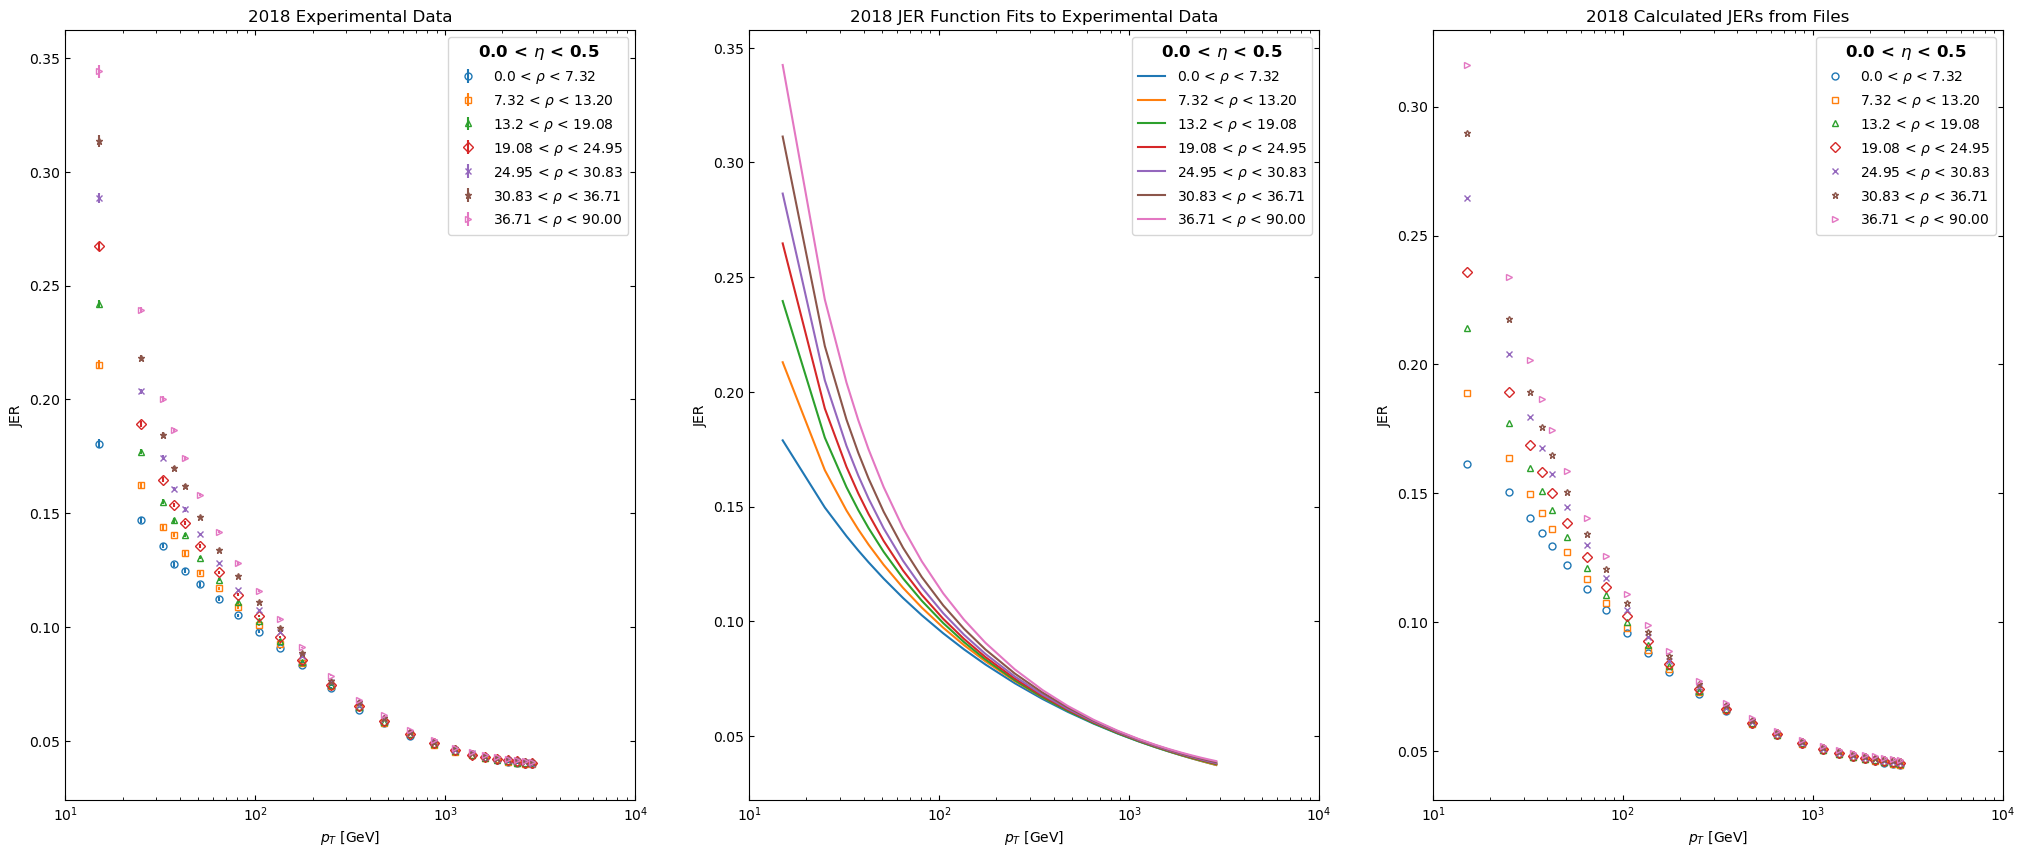

In [4]:
era_2018 = 2018

eta_range_1 = [(0.0, 0.5)]

rho_ranges = [(0., 7.32), (7.32, 13.2), (13.2, 19.08), (19.08, 24.95), (24.95, 30.83), (30.83, 36.71), (36.71, 90)]

reader = GaussianParametersReader(era_2018, eta_range_1, rho_ranges)
reader.read_gaussian_parameters()
pt_bin_lists_1, sigmas_lists_1, sigma_errs_lists_1, filenames_lists_1, dfs_1 = reader.extract_sigma_and_err()
    
fig, axs = plt.subplots(1, 3, figsize=(25, 10))

markers = ['o', 's', '^', 'D', 'x', '*', '>']
marker_size = 5 

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_1, sigma_errs_lists_1, filenames_lists_1)):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    
    axs[0].errorbar(pt_bin_centers, sigmas, yerr=sigma_errs, fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
    
    axs[0].set_title(f'{year} Experimental Data')
        
for i, (initial_guess, sigmas, sigma_errs, filename) in enumerate(zip(jer_parameters_2018_1, sigmas_lists_1, sigma_errs_lists_1, filenames_lists_1)):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    popt, pcov = curve_fit(jer_function, xdata=pt_bin_centers, ydata=sigmas, p0=initial_guess, maxfev=1000000)
        
    axs[1].plot(pt_bin_centers, jer_function(pt_bin_centers, *popt), markersize=marker_size, markerfacecolor='none', label=rho_labels)
        
    axs[1].set_title(f'{year} JER Function Fits to Experimental Data')
    
for i, (jer_value, filename) in enumerate(zip(calculated_jer_2018_1, filenames_lists_1)):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    
    axs[2].errorbar(pt_bin_centers, jer_value, fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
    
    axs[2].set_title(f'{year} Calculated JERs from Files')
    
axs[0].set_xlabel(r"$p_T$ [GeV]")
axs[0].set_ylabel("JER")
axs[0].set_xscale('log')
axs[0].set_xlim(10, 10000)
legend = axs[0].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')

axs[1].set_xlabel(r"$p_T$ [GeV]")
axs[1].set_ylabel("JER")
axs[1].set_xscale('log')
axs[1].set_xlim(10, 10000)
legend = axs[1].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')

axs[2].set_xlabel(r"$p_T$ [GeV]")
axs[2].set_ylabel("JER")
axs[2].set_xscale('log')
axs[2].set_xlim(10, 10000)
legend = axs[2].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')

for ax in axs:
    ax.tick_params(axis='x', direction='in', which='both', bottom=True, top=True)
    ax.tick_params(axis='y', direction='in', which='both', left=True, right=True)
plt.show()

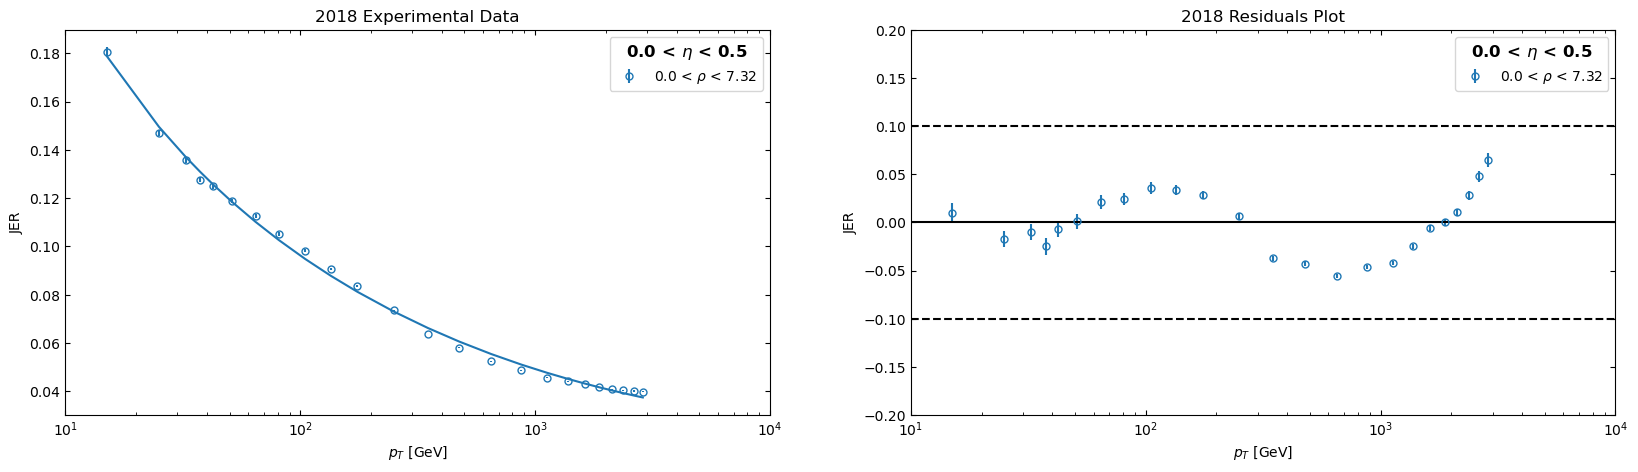

In [5]:
era_2018 = 2018

eta_range_1 = [(0.0, 0.5)]

rho_ranges = [(0., 7.32)]

initial_guesses = jer_parameters_2018_1[0]

reader = GaussianParametersReader(era_2018, eta_range_1, rho_ranges)
reader.read_gaussian_parameters()
pt_bin_lists_1, sigmas_lists_1, sigma_errs_lists_1, filenames_lists_1, dfs_1 = reader.extract_sigma_and_err()

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

markers = ['o', 's', '^', 'D', 'x', '*', '>']
marker_size = 5 

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_1, sigma_errs_lists_1, filenames_lists_1)):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])]
    popt, pcov = curve_fit(jer_function, xdata=pt_bin_centers, ydata=sigmas, p0=initial_guesses, maxfev=1000000)
    
    axs[0].errorbar(pt_bin_centers, sigmas, yerr=sigma_errs, fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels, color=color)
    axs[0].plot(pt_bin_centers, jer_function(pt_bin_centers, *popt), color=color)
    
    axs[0].set_title(f'{year} Experimental Data')

    experimental = sigmas
    accepted = jer_function(pt_bin_centers, *popt)
    error = ((experimental - accepted) / accepted)
    #error = (experimental  / accepted)
    error_uncertainty = sigma_errs / accepted
    
    axs[1].errorbar(pt_bin_centers, error, yerr=error_uncertainty, marker=marker, markersize=marker_size, markerfacecolor='none', color=color, linestyle='none', label=rho_labels)
    
    axs[1].set_title(f'{year} Residuals Plot')
    
axs[0].set_xlabel(r"$p_T$ [GeV]")
axs[0].set_ylabel("JER")
axs[0].set_xscale('log')
axs[0].set_xlim(10, 10000)
legend = axs[0].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')

axs[1].set_xlabel(r"$p_T$ [GeV]")
axs[1].set_ylabel("JER")
axs[1].set_xscale('log')
axs[1].set_xlim(10, 10000)
axs[1].set_ylim(-0.2, 0.2)
axs[1].axhline(y=0, color='k', linestyle='-')
axs[1].axhline(y=0.1, color='k', linestyle='--')
axs[1].axhline(y=-0.1, color='k', linestyle='--')
legend = axs[1].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')
    
for ax in axs:
    ax.tick_params(axis='x', direction='in', which='both', bottom=True, top=True)
    ax.tick_params(axis='y', direction='in', which='both', left=True, right=True)
plt.show()

### 2018 Dataset

In [6]:
era = 2018

eta_ranges = [
    (0.0, 0.5), (0.5, 0.8), (0.8, 1.1), (1.1, 1.3), (1.3, 1.7),
    (1.7, 1.9), (1.9, 2.1), (2.1, 2.3), (2.3, 2.5), (2.5, 2.8),
    (2.8, 3.0), (3.0, 3.2), (3.2, 4.7)
]

rho_ranges = [(0., 7.32), (7.32, 13.2), (13.2, 19.08), (19.08, 24.95), (24.95, 30.83), (30.83, 36.71), (36.71, 90)]

jer_parameters_lists = []
calculated_jer_lists = []

for i, eta_range in enumerate(eta_ranges):
    jer_calculator = JERCalculator("../jer_files/Summer19UL18_JRV2_MC_PtResolution_AK4PFchs.txt", eta_min=eta_range[0], eta_max=eta_range[1], rho_min=0, rho_max=90)
    
    jer_parameters = jer_calculator.extract_parameters()
    calculated_jer = jer_calculator.compute_jer(pt_bin_centers)
    
    jer_parameters_lists.append(jer_parameters)
    calculated_jer_lists.append(calculated_jer)
     
pt_bin_lists = []
sigmas_lists = []
sigma_errs_lists = []
filenames_lists = []
dfs_lists = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists.append(pt_bins)
    sigmas_lists.append(sigmas)
    sigma_errs_lists.append(sigma_errs)
    filenames_lists.append(filenames)
    dfs_lists.append(dfs)

### Barrel measurements

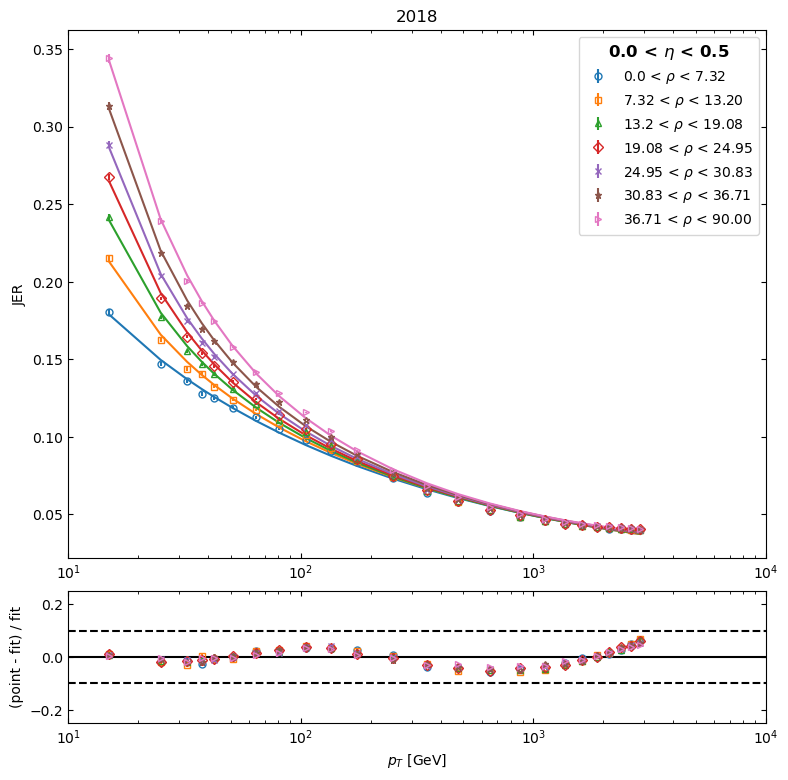

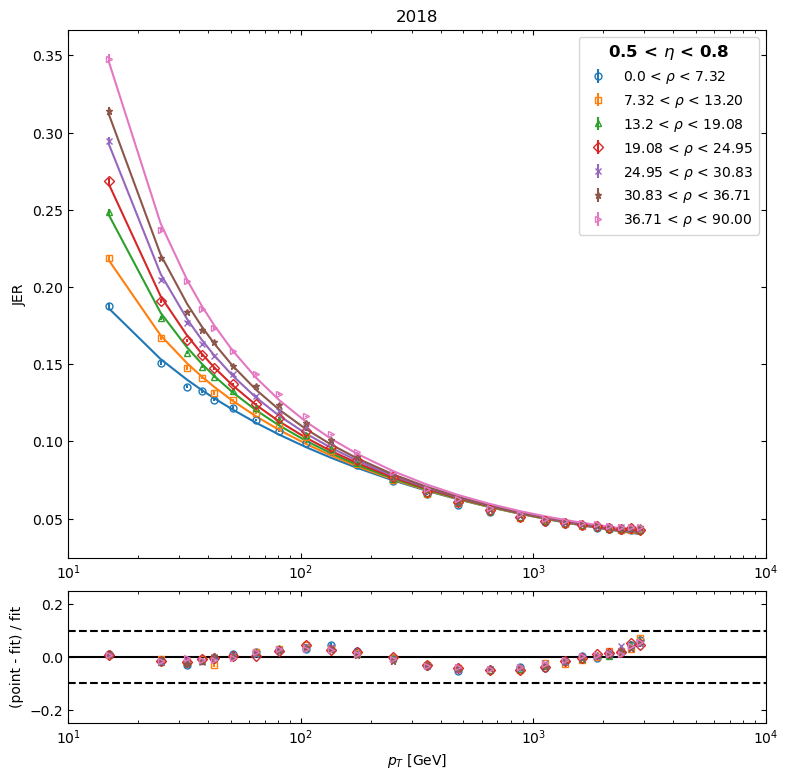

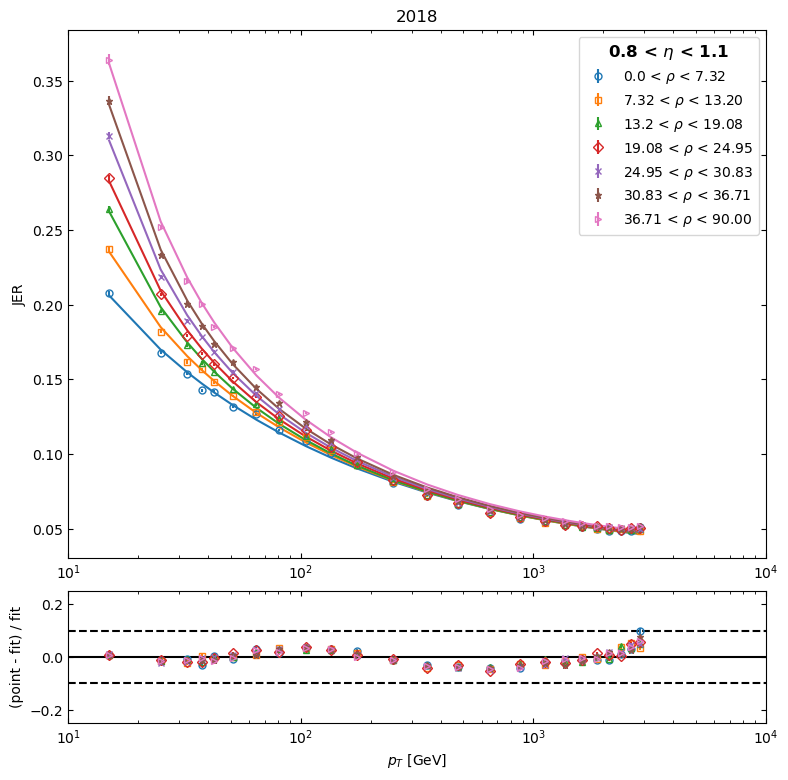

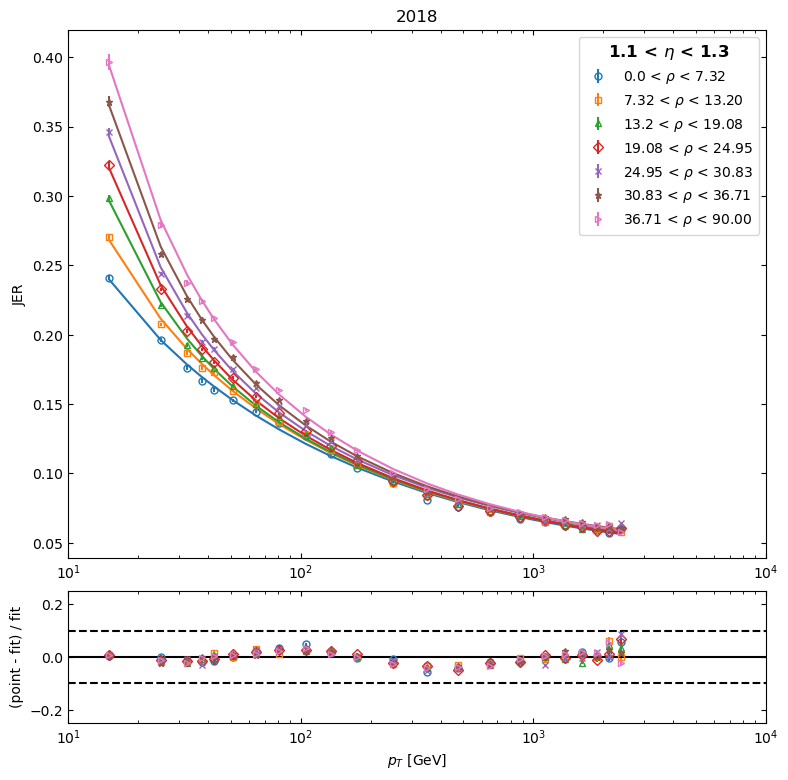

In [7]:
plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[0], sigma_errs_list=sigma_errs_lists[0], filenames_list=filenames_lists[0], jer_parameters_list=jer_parameters_lists[0], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=24)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[1], sigma_errs_list=sigma_errs_lists[1], filenames_list=filenames_lists[1], jer_parameters_list=jer_parameters_lists[1], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=24)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[2], sigma_errs_list=sigma_errs_lists[2], filenames_list=filenames_lists[2], jer_parameters_list=jer_parameters_lists[2], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=24)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[3], sigma_errs_list=sigma_errs_lists[3], filenames_list=filenames_lists[3], jer_parameters_list=jer_parameters_lists[3], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=22)

### Endcap measurements

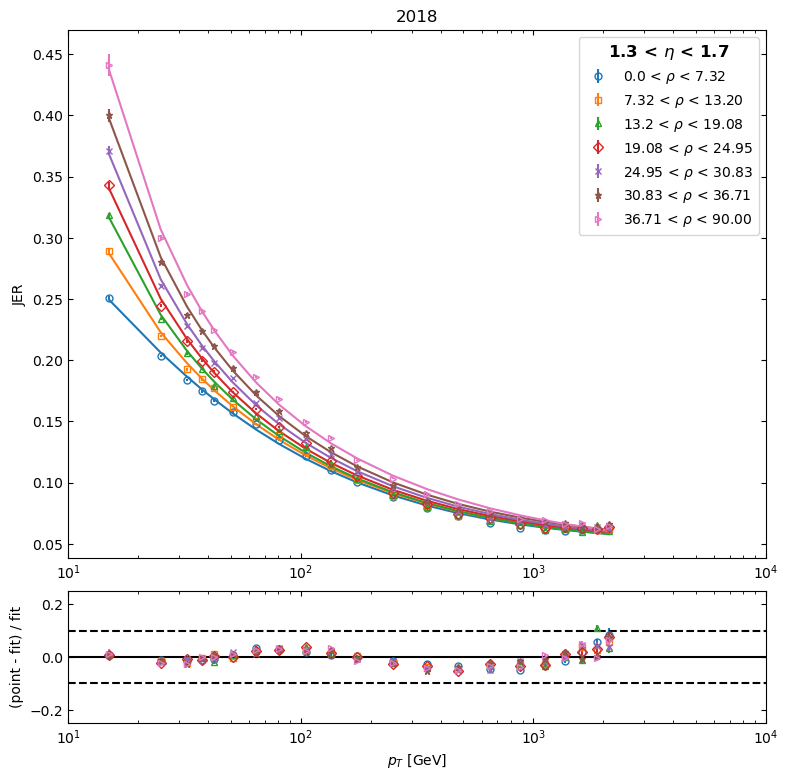

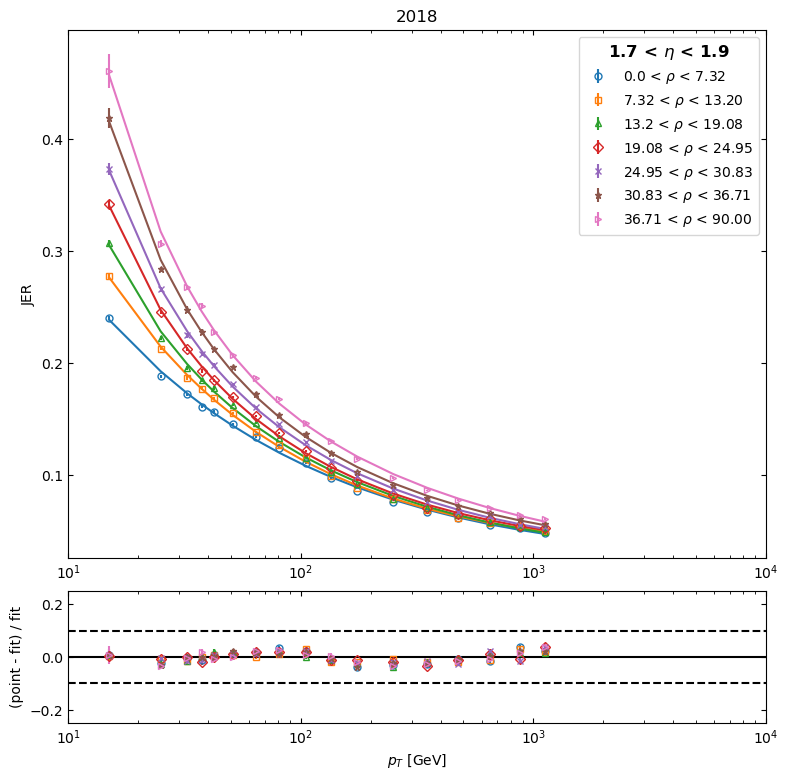

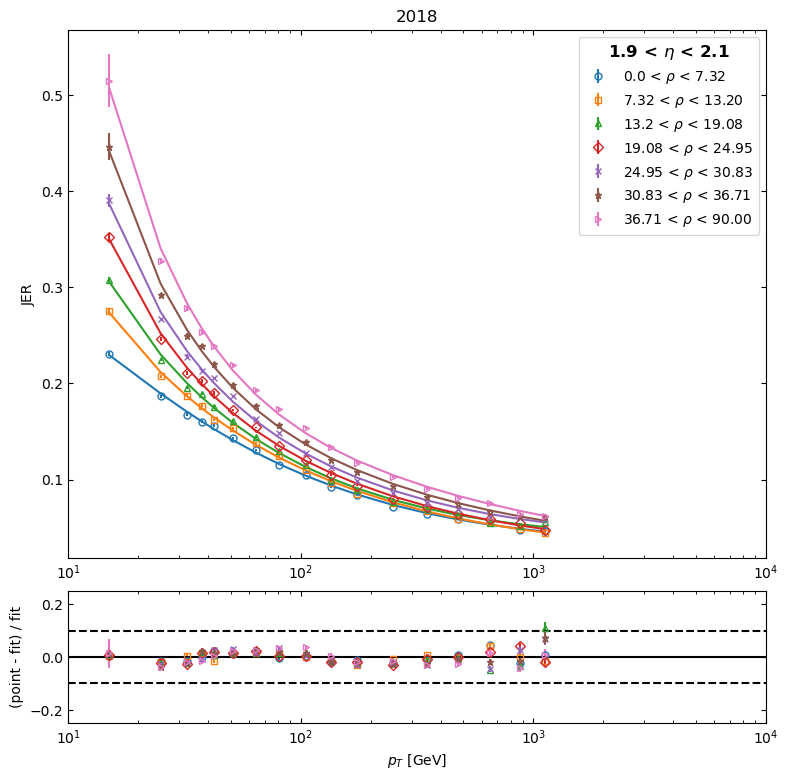

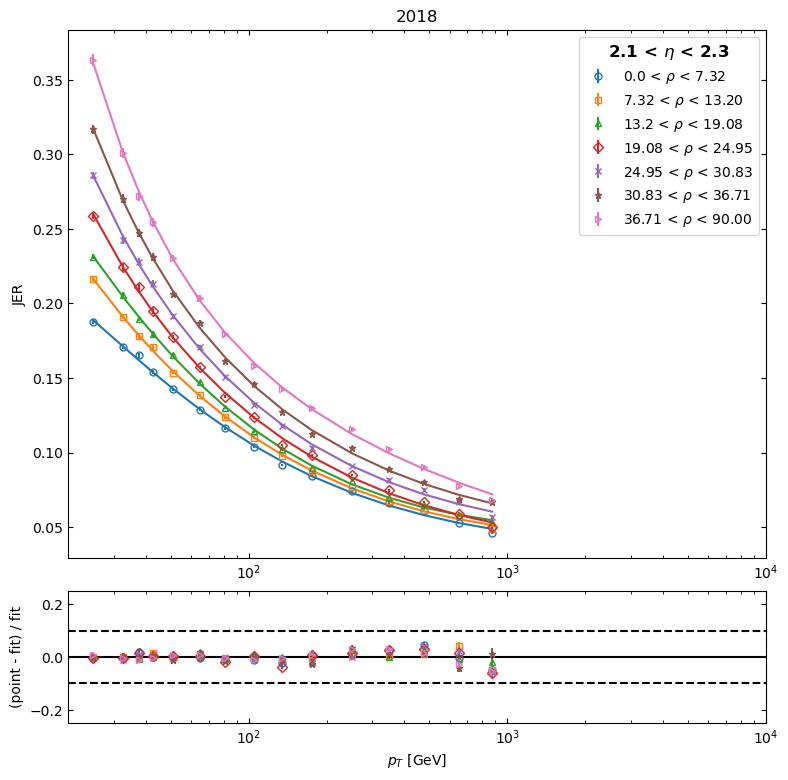

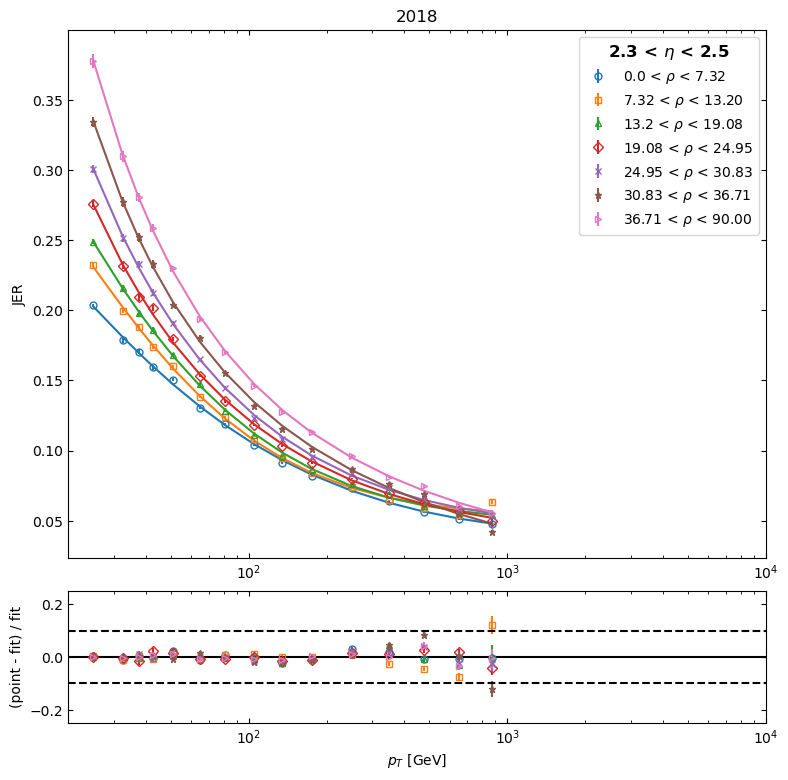

In [8]:
plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[4], sigma_errs_list=sigma_errs_lists[4], filenames_list=filenames_lists[4], jer_parameters_list=jer_parameters_lists[4], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=21)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[5], sigma_errs_list=sigma_errs_lists[5], filenames_list=filenames_lists[5], jer_parameters_list=jer_parameters_lists[5], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=17)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[6], sigma_errs_list=sigma_errs_lists[6], filenames_list=filenames_lists[6], jer_parameters_list=jer_parameters_lists[6], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=17)         

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[7], sigma_errs_list=sigma_errs_lists[7], filenames_list=filenames_lists[7], jer_parameters_list=jer_parameters_lists[7], 
         lower_xlimit=20, upper_xlimit=10000, lower_pt_bin=1, upper_pt_bin=16)          # Covariance error when running full notebook

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[8], sigma_errs_list=sigma_errs_lists[8], filenames_list=filenames_lists[8], jer_parameters_list=jer_parameters_lists[8], 
         lower_xlimit=20, upper_xlimit=10000, lower_pt_bin=1, upper_pt_bin=16)

### Forward measurements

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


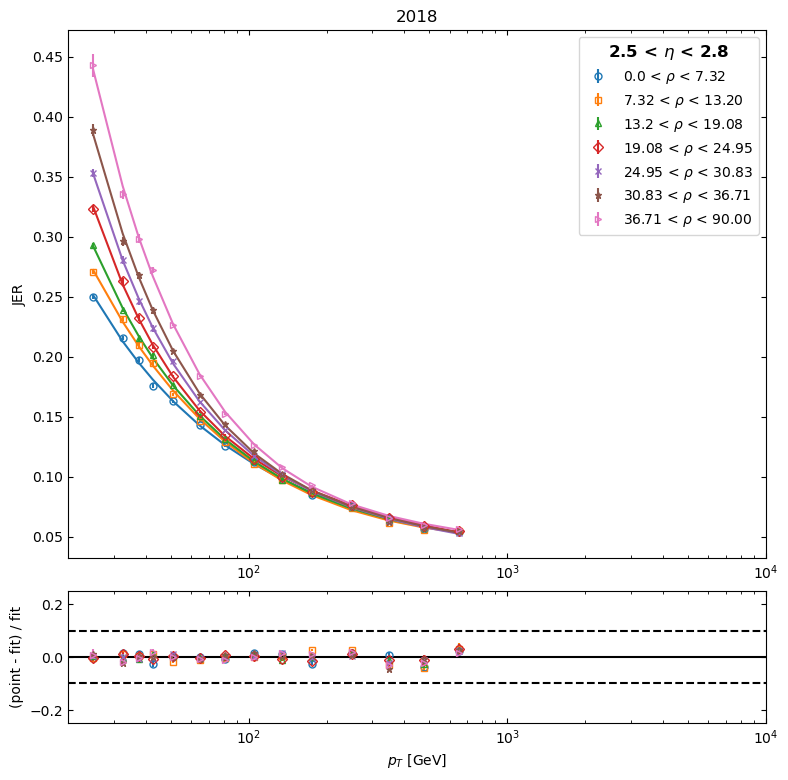

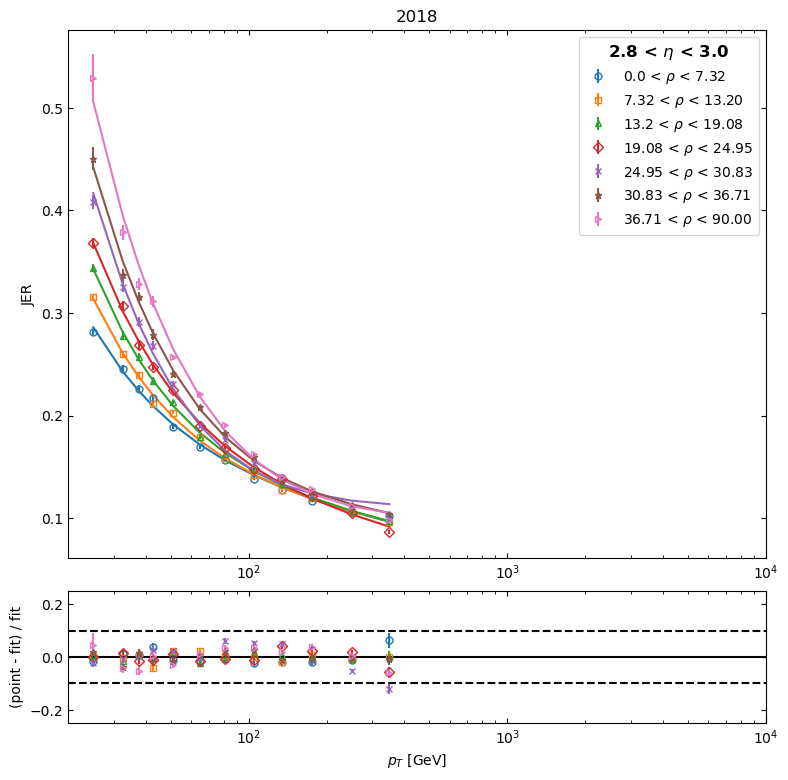

/home/cms-jovyan/QCD_JER_Analysis/Jet_Energy_Resolution/python/smp_utils.py:192: RuntimeWarning: overflow encountered in power
  return np.sqrt(parameter_0 * np.abs(parameter_0) / (pt * pt) + parameter_1 * parameter_1 * np.power(pt, parameter_3) + parameter_2 * parameter_2)


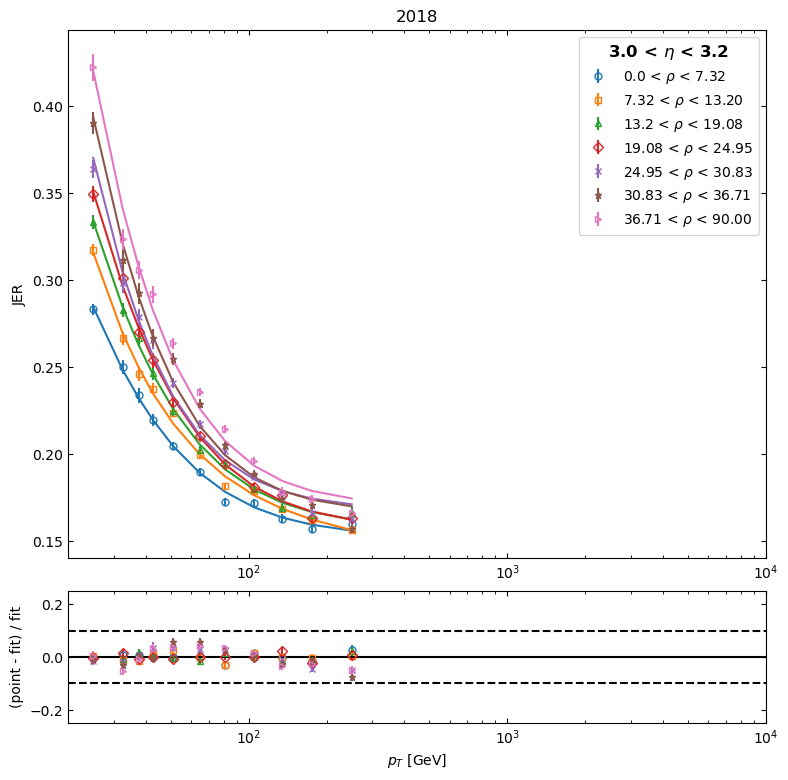

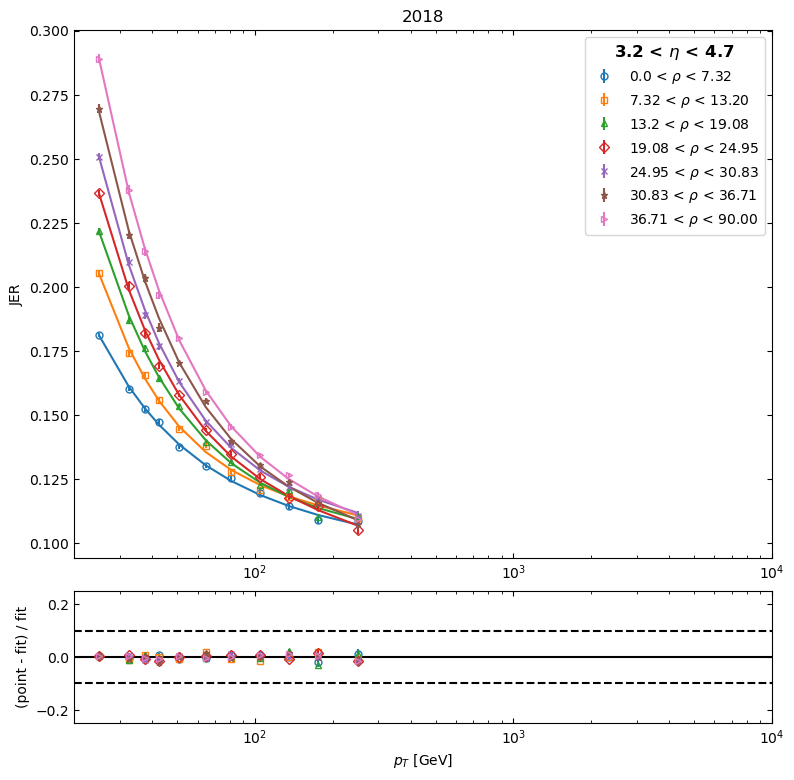

In [9]:
plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[9], sigma_errs_list=sigma_errs_lists[9], filenames_list=filenames_lists[9], jer_parameters_list=jer_parameters_lists[9], 
         lower_xlimit=20, upper_xlimit=10000, lower_pt_bin=1, upper_pt_bin=15)           # Covariance error when running single cell  

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[10], sigma_errs_list=sigma_errs_lists[10], filenames_list=filenames_lists[10], jer_parameters_list=jer_parameters_lists[10], 
         lower_xlimit=20, upper_xlimit=10000, lower_pt_bin=1, upper_pt_bin=13)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[11], sigma_errs_list=sigma_errs_lists[11], filenames_list=filenames_lists[11], jer_parameters_list=jer_parameters_lists[11], 
         lower_xlimit=20, upper_xlimit=10000, lower_pt_bin=1, upper_pt_bin=12)          # Covariance error when running full notebook

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[12], sigma_errs_list=sigma_errs_lists[12], filenames_list=filenames_lists[12], jer_parameters_list=jer_parameters_lists[12], 
         lower_xlimit=20, upper_xlimit=10000, lower_pt_bin=1, upper_pt_bin=12)

### 2017 Dataset

In [10]:
era = 2017

eta_ranges = [
    (0.0, 0.5), (0.5, 0.8), (0.8, 1.1), (1.1, 1.3), (1.3, 1.7),
    (1.7, 1.9), (1.9, 2.1), (2.1, 2.3), (2.3, 2.5), (2.5, 2.8),
    (2.8, 3.0), (3.0, 3.2), (3.2, 4.7)
]

rho_ranges = [(0., 7.32), (7.32, 13.2), (13.2, 19.08), (19.08, 24.95), (24.95, 30.83), (30.83, 36.71), (36.71, 90)]

jer_parameters_lists = []
calculated_jer_lists = []

for i, eta_range in enumerate(eta_ranges):
    jer_calculator = JERCalculator("../jer_files/Summer19UL17_JRV2_MC_PtResolution_AK4PFchs.txt", eta_min=eta_range[0], eta_max=eta_range[1], rho_min=0, rho_max=90)
    
    jer_parameters = jer_calculator.extract_parameters()
    calculated_jer = jer_calculator.compute_jer(pt_bin_centers)
    
    jer_parameters_lists.append(jer_parameters)
    calculated_jer_lists.append(calculated_jer)
          
pt_bin_lists = []
sigmas_lists = []
sigma_errs_lists = []
filenames_lists = []
dfs_lists = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists.append(pt_bins)
    sigmas_lists.append(sigmas)
    sigma_errs_lists.append(sigma_errs)
    filenames_lists.append(filenames)
    dfs_lists.append(dfs)

### Barrel measurements

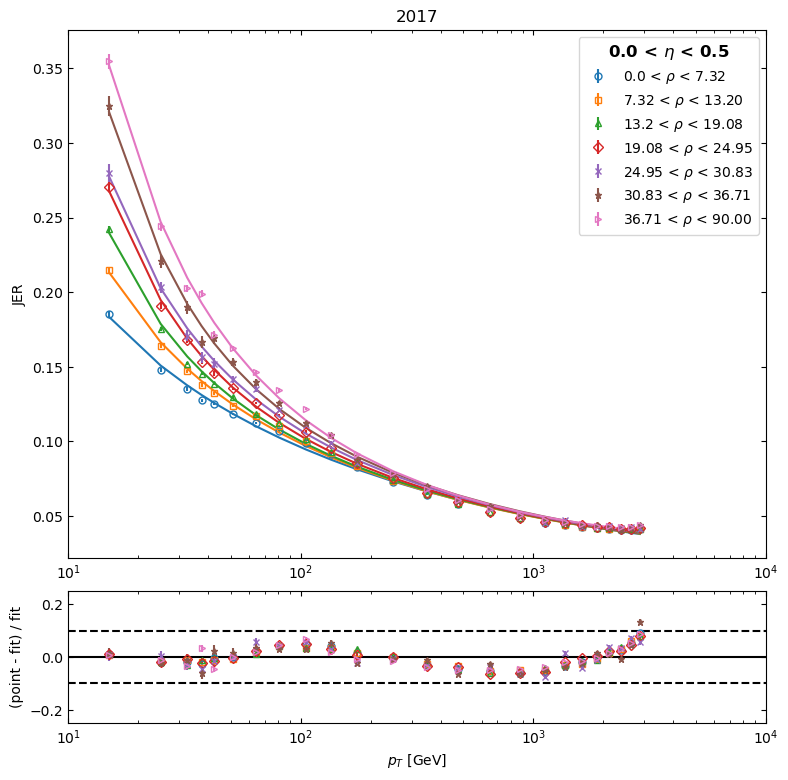

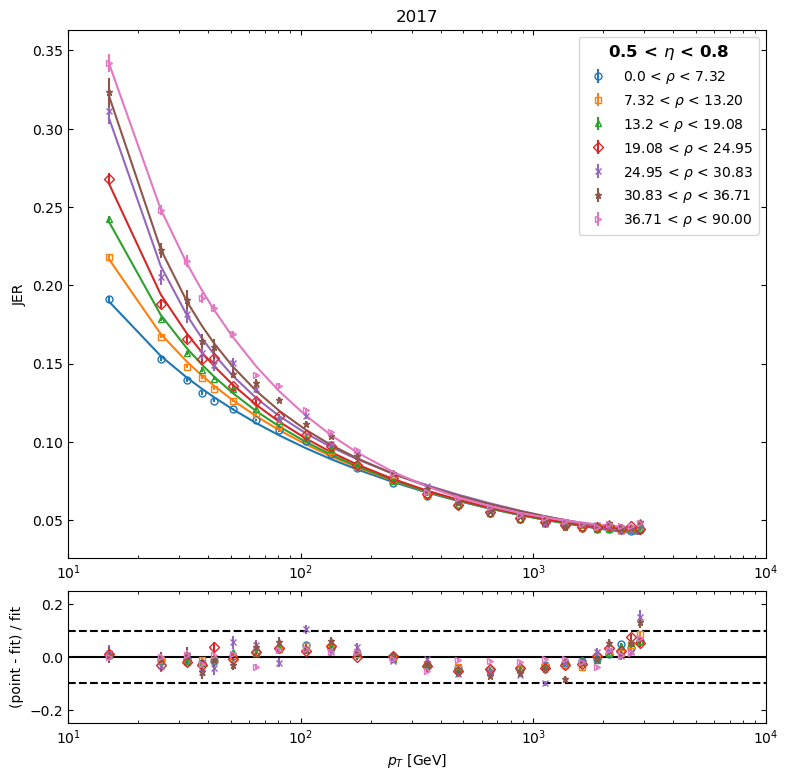

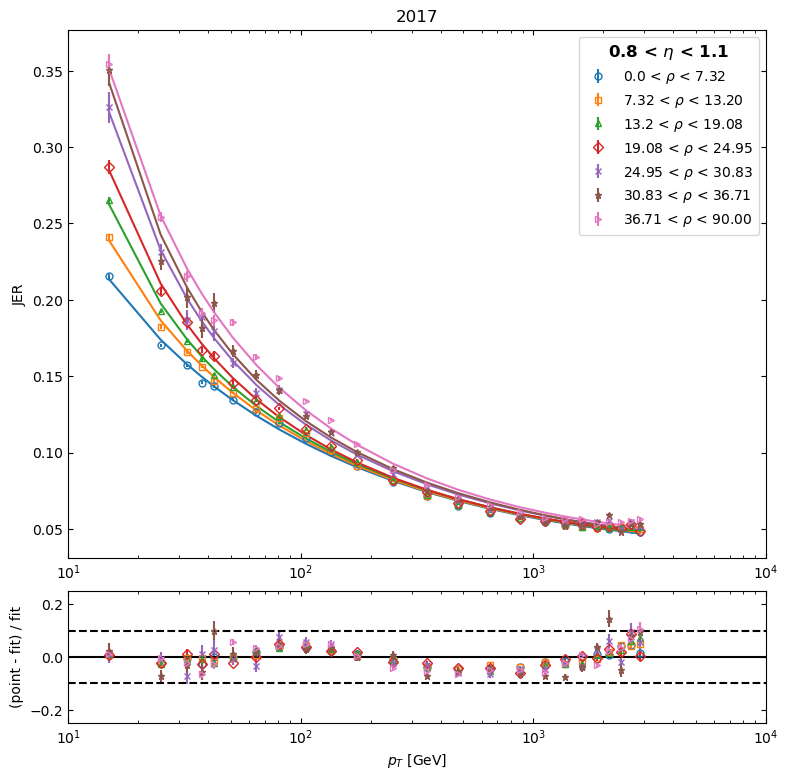

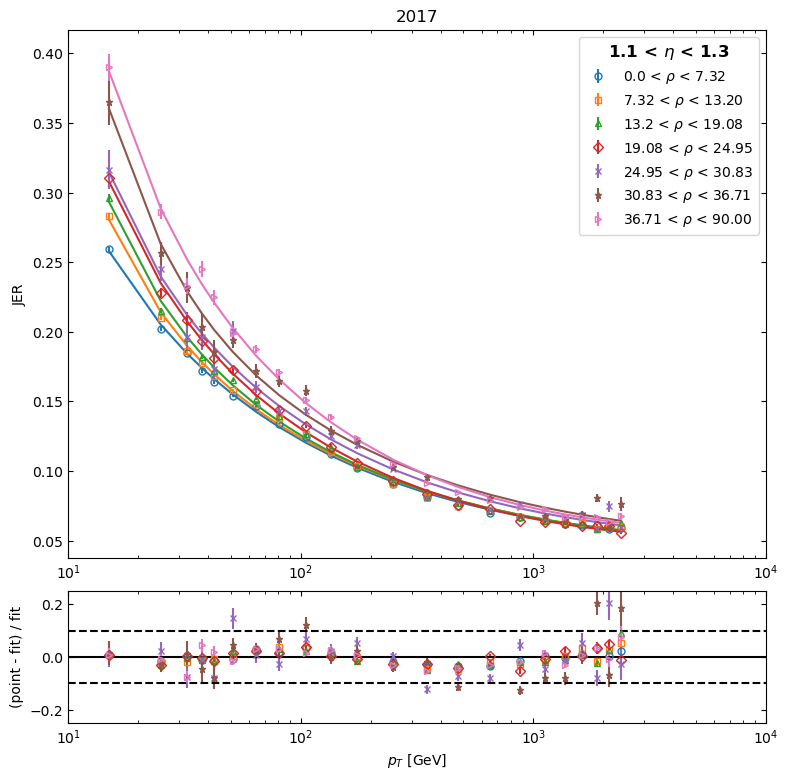

In [11]:
plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[0], sigma_errs_list=sigma_errs_lists[0], filenames_list=filenames_lists[0], jer_parameters_list=jer_parameters_lists[0], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=24)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[1], sigma_errs_list=sigma_errs_lists[1], filenames_list=filenames_lists[1], jer_parameters_list=jer_parameters_lists[1], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=24)         

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[2], sigma_errs_list=sigma_errs_lists[2], filenames_list=filenames_lists[2], jer_parameters_list=jer_parameters_lists[2], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=24)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[3], sigma_errs_list=sigma_errs_lists[3], filenames_list=filenames_lists[3], jer_parameters_list=jer_parameters_lists[3], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=22)

### Endcap measurements

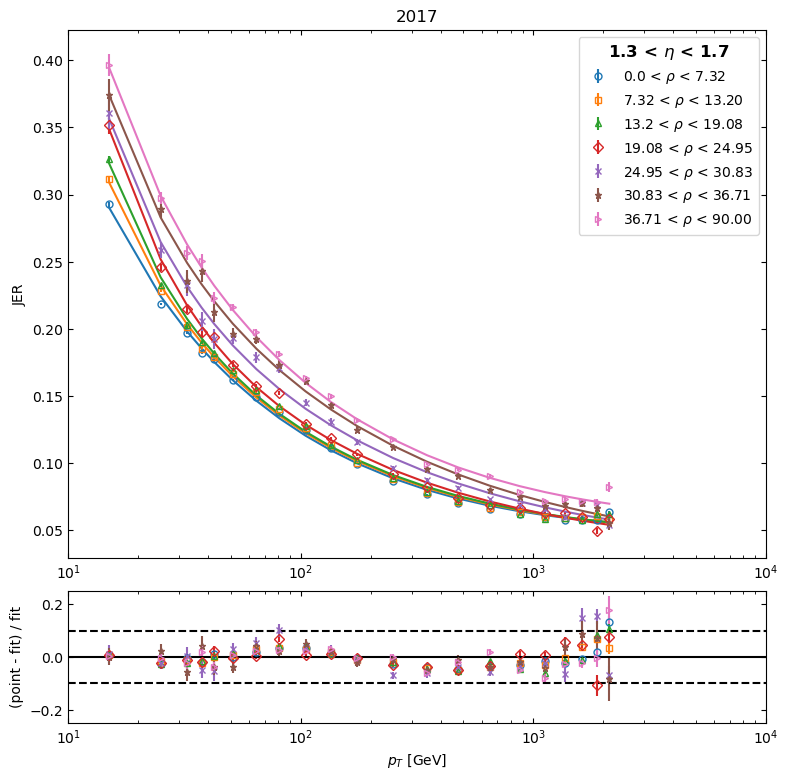

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


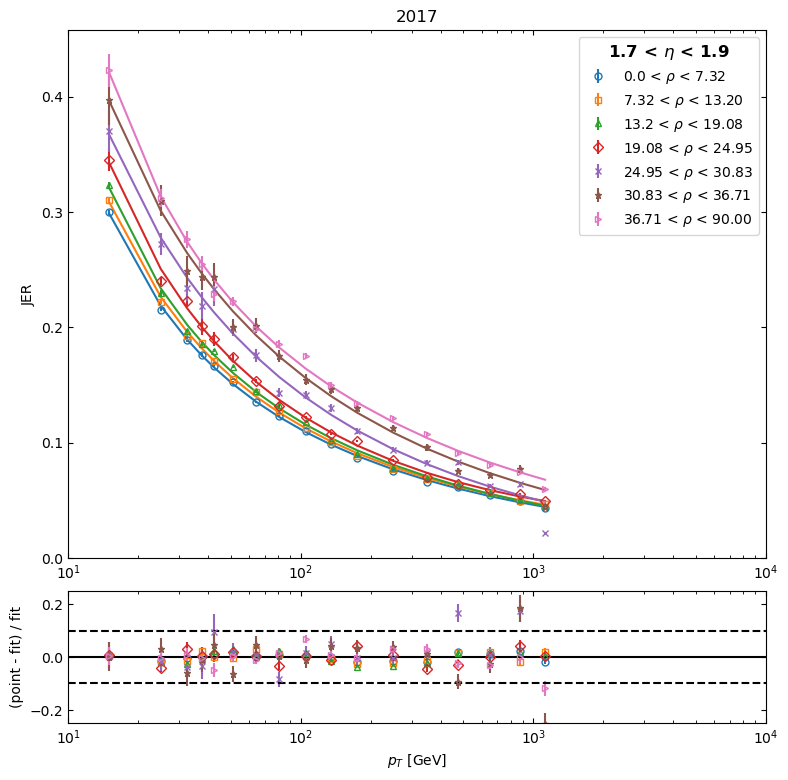

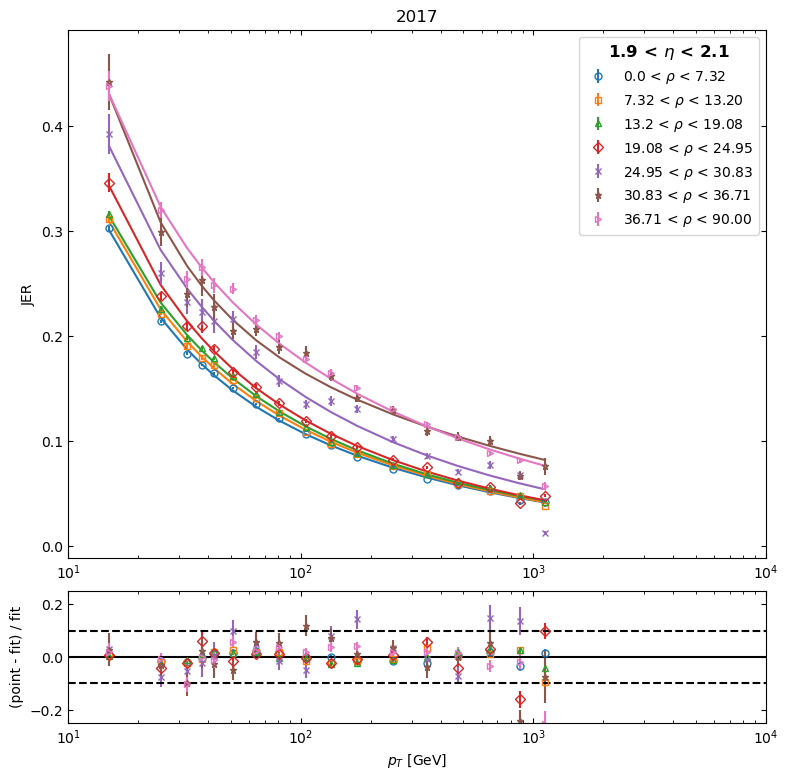

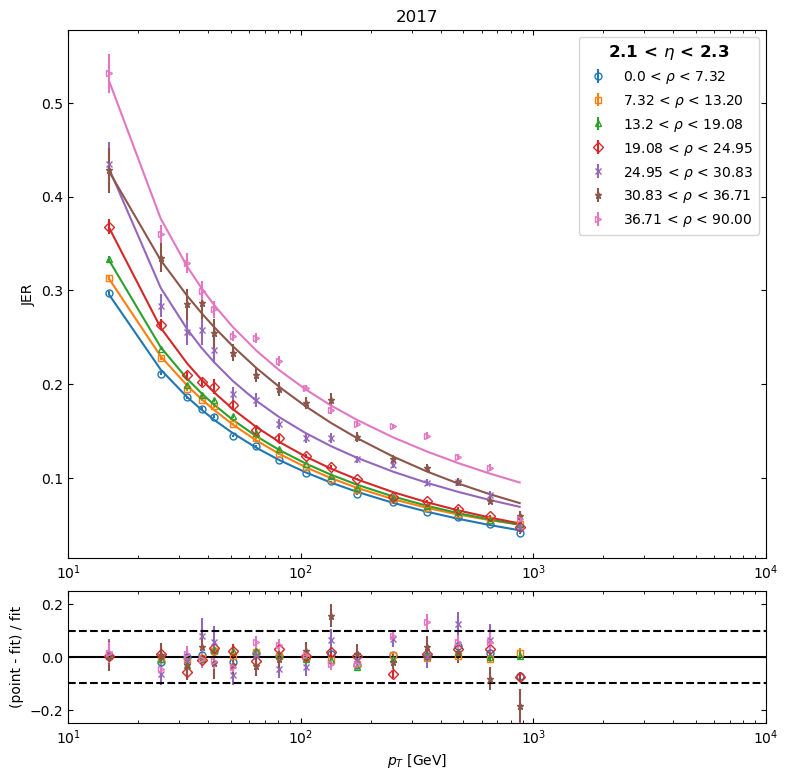

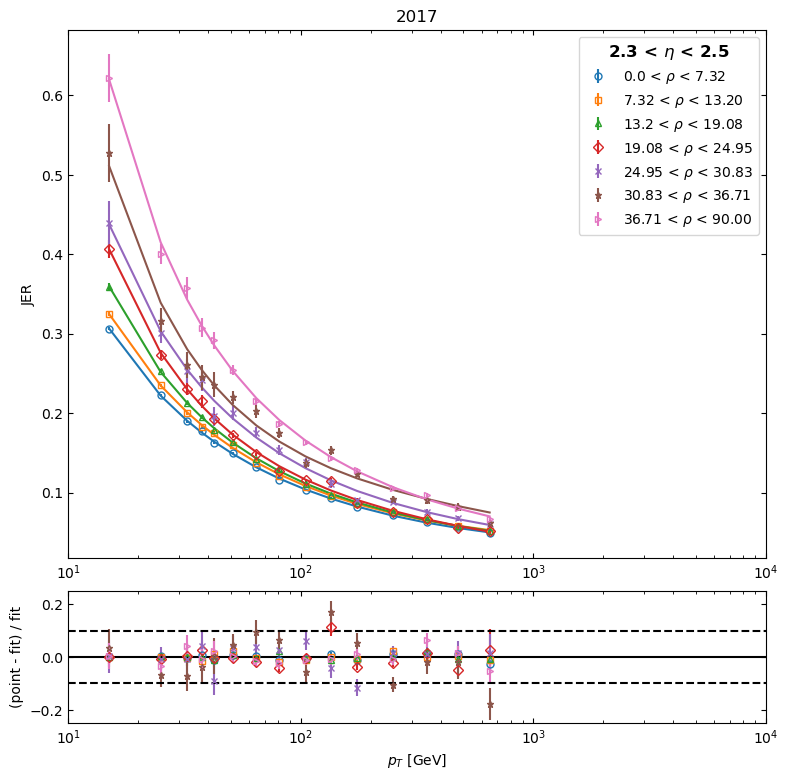

In [12]:
plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[4], sigma_errs_list=sigma_errs_lists[4], filenames_list=filenames_lists[4], jer_parameters_list=jer_parameters_lists[4], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=21)     

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[5], sigma_errs_list=sigma_errs_lists[5], filenames_list=filenames_lists[5], jer_parameters_list=jer_parameters_lists[5], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=17)          # Covariance error when running full notebook 

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[6], sigma_errs_list=sigma_errs_lists[6], filenames_list=filenames_lists[6], jer_parameters_list=jer_parameters_lists[6], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=17) 

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[7], sigma_errs_list=sigma_errs_lists[7], filenames_list=filenames_lists[7], jer_parameters_list=jer_parameters_lists[7], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=16)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[8], sigma_errs_list=sigma_errs_lists[8], filenames_list=filenames_lists[8], jer_parameters_list=jer_parameters_lists[8], 
         lower_xlimit=10, upper_xlimit=10000, lower_pt_bin=0, upper_pt_bin=15)

### Forward measurements

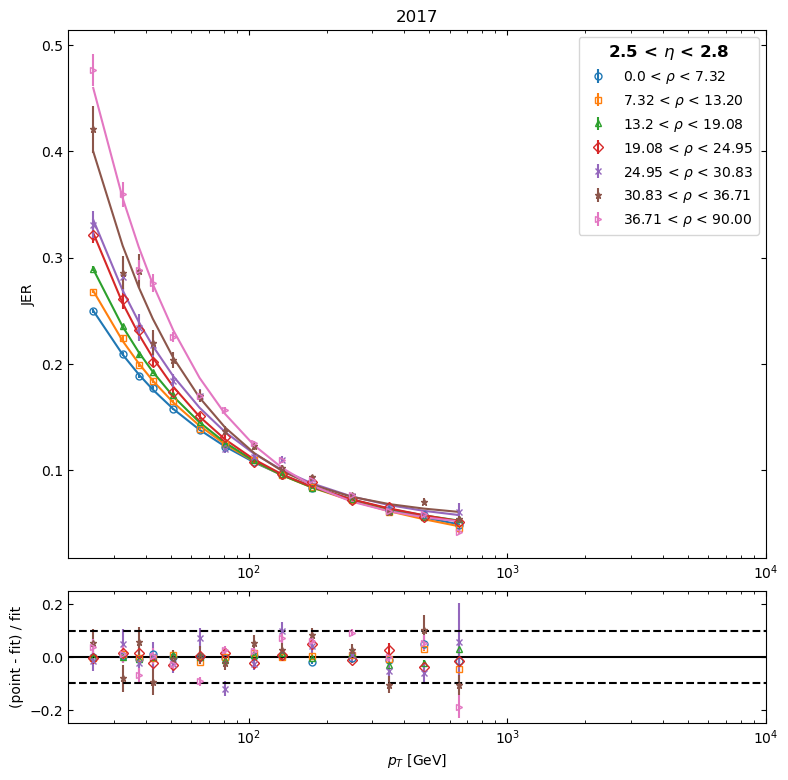

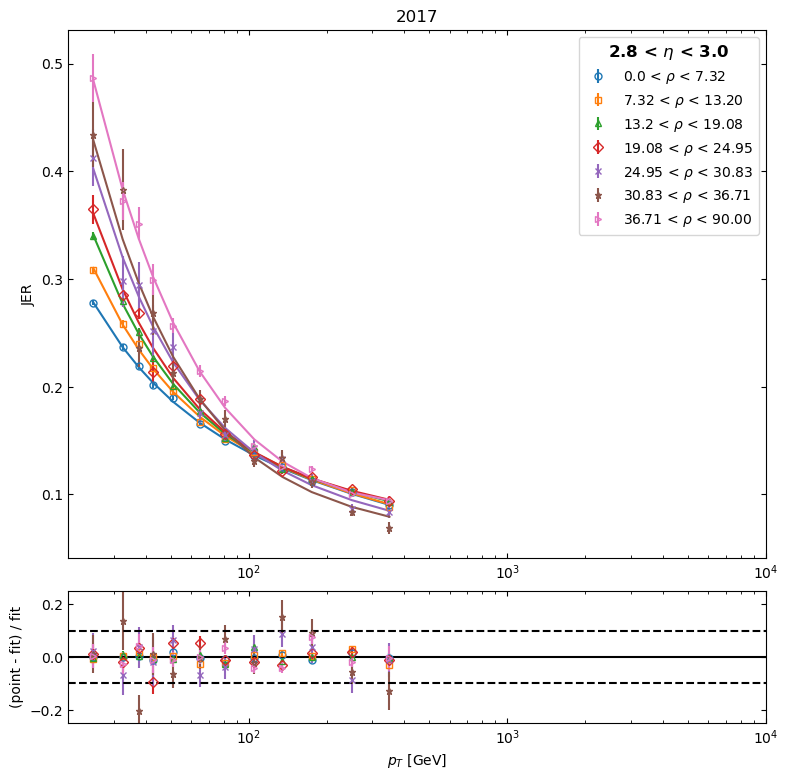

/home/cms-jovyan/QCD_JER_Analysis/Jet_Energy_Resolution/python/smp_utils.py:192: RuntimeWarning: overflow encountered in power
  return np.sqrt(parameter_0 * np.abs(parameter_0) / (pt * pt) + parameter_1 * parameter_1 * np.power(pt, parameter_3) + parameter_2 * parameter_2)


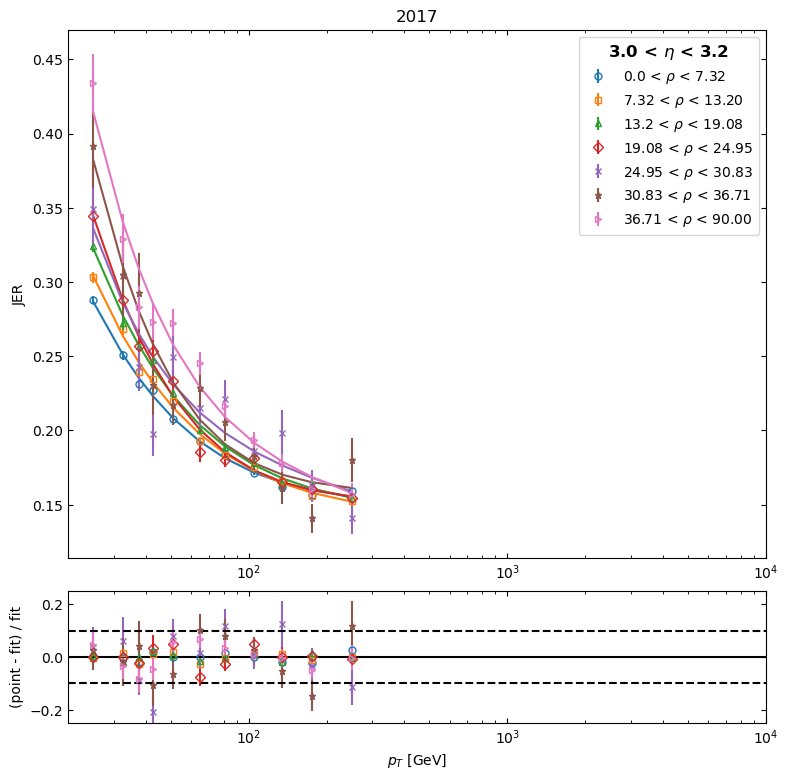

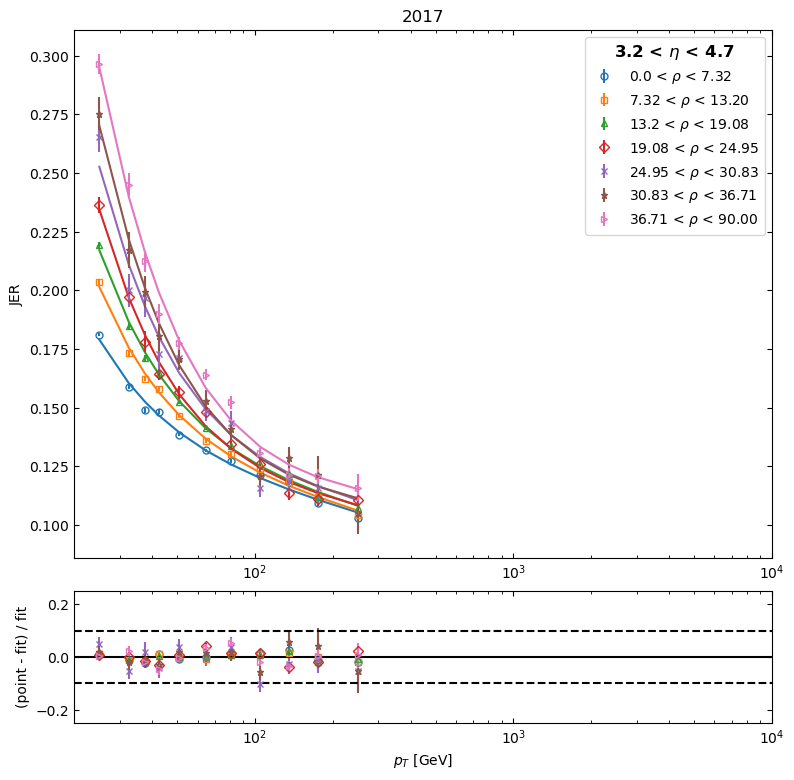

In [13]:
plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[9], sigma_errs_list=sigma_errs_lists[9], filenames_list=filenames_lists[9], jer_parameters_list=jer_parameters_lists[9], 
         lower_xlimit=20, upper_xlimit=10000, lower_pt_bin=1, upper_pt_bin=15)           # Covariance error when running single cell 

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[10], sigma_errs_list=sigma_errs_lists[10], filenames_list=filenames_lists[10], jer_parameters_list=jer_parameters_lists[10], 
         lower_xlimit=20, upper_xlimit=10000, lower_pt_bin=1, upper_pt_bin=13)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[11], sigma_errs_list=sigma_errs_lists[11], filenames_list=filenames_lists[11], jer_parameters_list=jer_parameters_lists[11], 
         lower_xlimit=20, upper_xlimit=10000, lower_pt_bin=1, upper_pt_bin=12)          # Covariance error when running full notebook 

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[12], sigma_errs_list=sigma_errs_lists[12], filenames_list=filenames_lists[12], jer_parameters_list=jer_parameters_lists[12], 
         lower_xlimit=20, upper_xlimit=10000, lower_pt_bin=1, upper_pt_bin=12)

### 2016APV Dataset

In [14]:
era = '2016APV'

eta_ranges = [
    (0.0, 0.5), (0.5, 0.8), (0.8, 1.1), (1.1, 1.3), (1.3, 1.7),
    (1.7, 1.9), (1.9, 2.1), (2.1, 2.3), (2.3, 2.5), (2.5, 2.8),
    (2.8, 3.0), (3.0, 3.2), (3.2, 4.7)
]

rho_ranges = [(0., 7.32), (7.32, 13.2), (13.2, 19.08), (19.08, 24.95), (24.95, 30.83), (30.83, 36.71), (36.71, 90)]

jer_parameters_lists = []
calculated_jer_lists = []

for i, eta_range in enumerate(eta_ranges):
    jer_calculator = JERCalculator("../jer_files/Summer20UL16APV_JRV3_MC_PtResolution_AK4PFchs.txt", eta_min=eta_range[0], eta_max=eta_range[1], rho_min=0, rho_max=90)
    
    jer_parameters = jer_calculator.extract_parameters()
    calculated_jer = jer_calculator.compute_jer(pt_bin_centers)
    
    jer_parameters_lists.append(jer_parameters)
    calculated_jer_lists.append(calculated_jer)
    
pt_bin_lists = []
sigmas_lists = []
sigma_errs_lists = []
filenames_lists = []
dfs_lists = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists.append(pt_bins)
    sigmas_lists.append(sigmas)
    sigma_errs_lists.append(sigma_errs)
    filenames_lists.append(filenames)
    dfs_lists.append(dfs)

### Barrel measurements

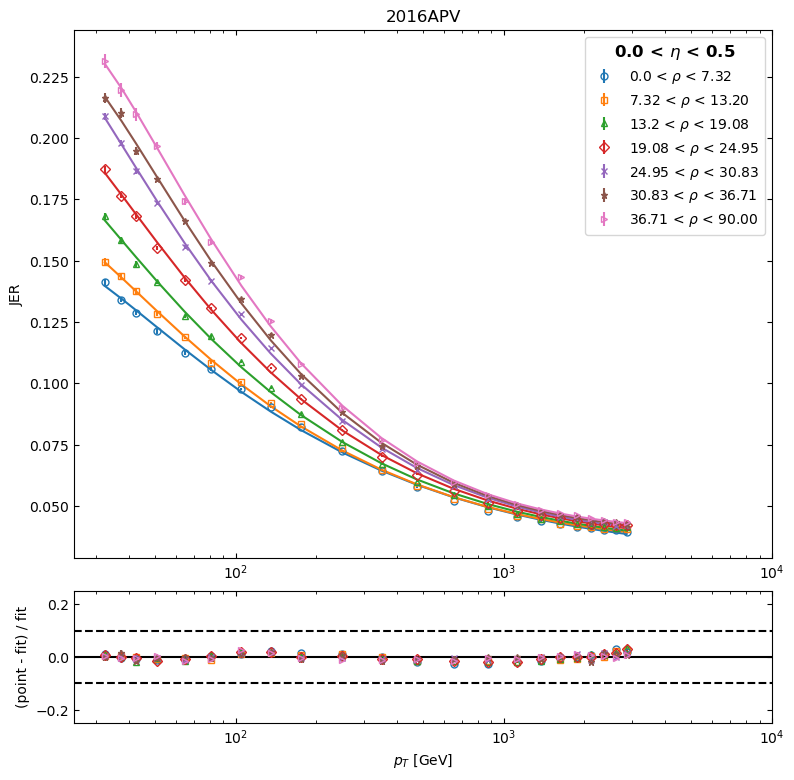

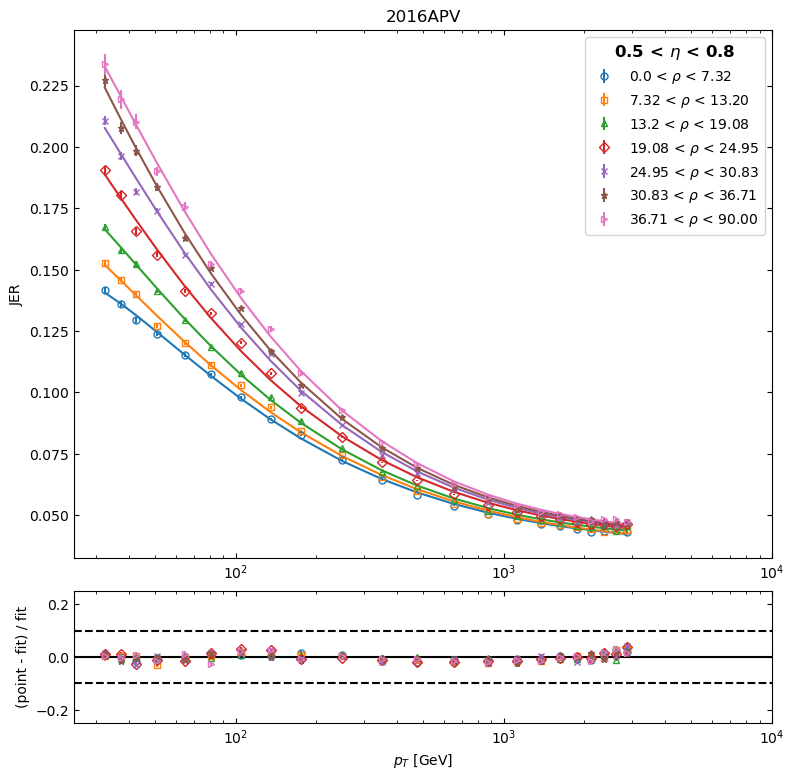

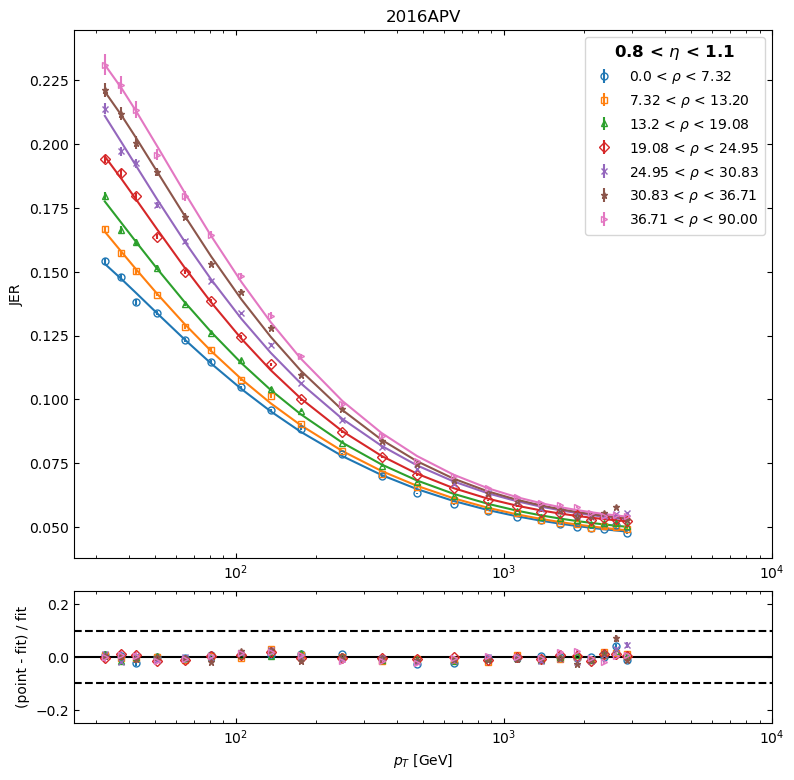

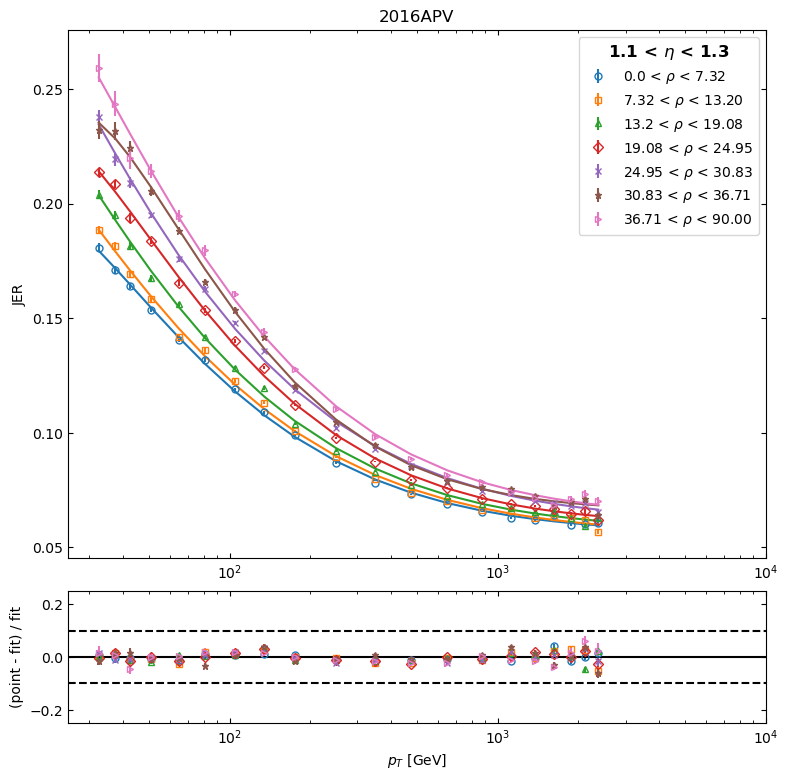

In [15]:
plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[0], sigma_errs_list=sigma_errs_lists[0], filenames_list=filenames_lists[0], jer_parameters_list=jer_parameters_lists[0], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=24)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[1], sigma_errs_list=sigma_errs_lists[1], filenames_list=filenames_lists[1], jer_parameters_list=jer_parameters_lists[1], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=24)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[2], sigma_errs_list=sigma_errs_lists[2], filenames_list=filenames_lists[2], jer_parameters_list=jer_parameters_lists[2], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=24)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[3], sigma_errs_list=sigma_errs_lists[3], filenames_list=filenames_lists[3], jer_parameters_list=jer_parameters_lists[3], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=22)

### Endcap measurements

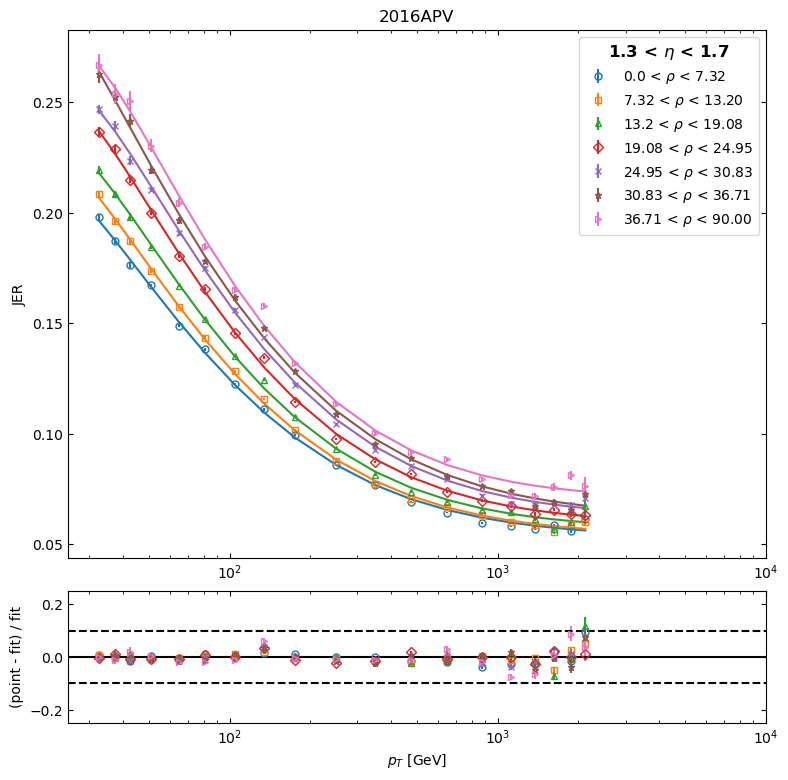

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


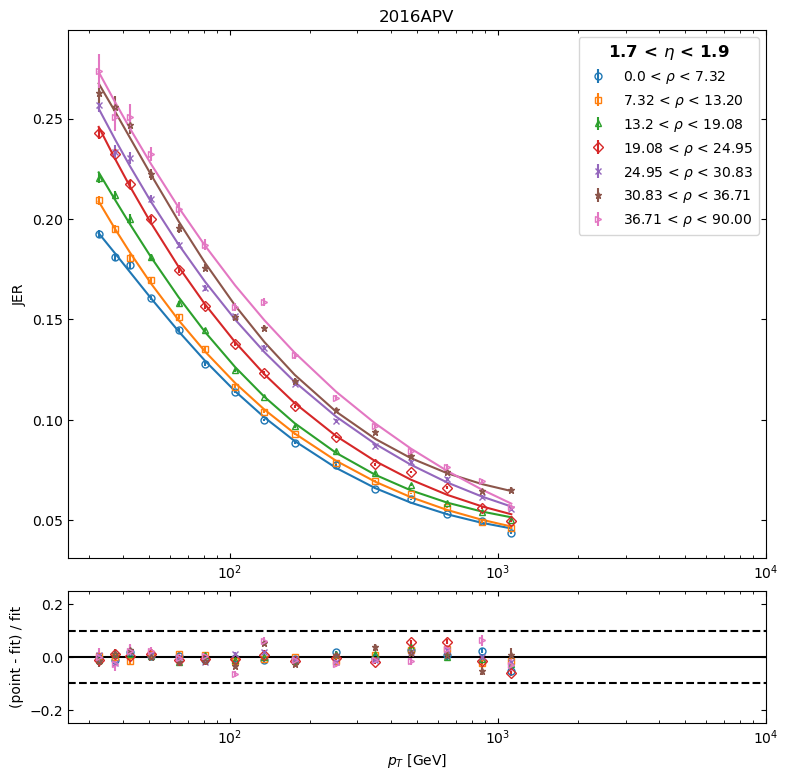

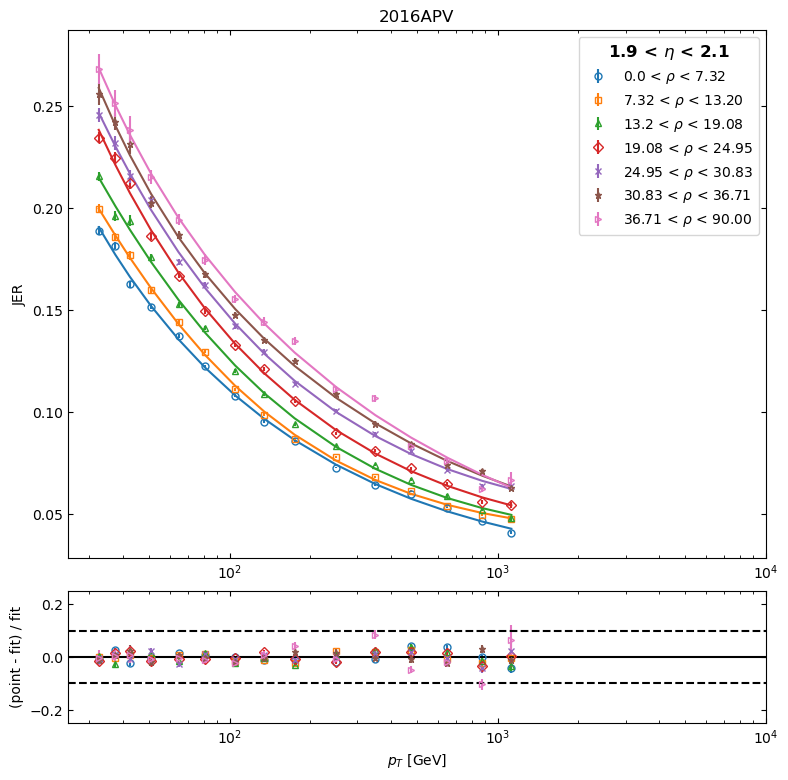

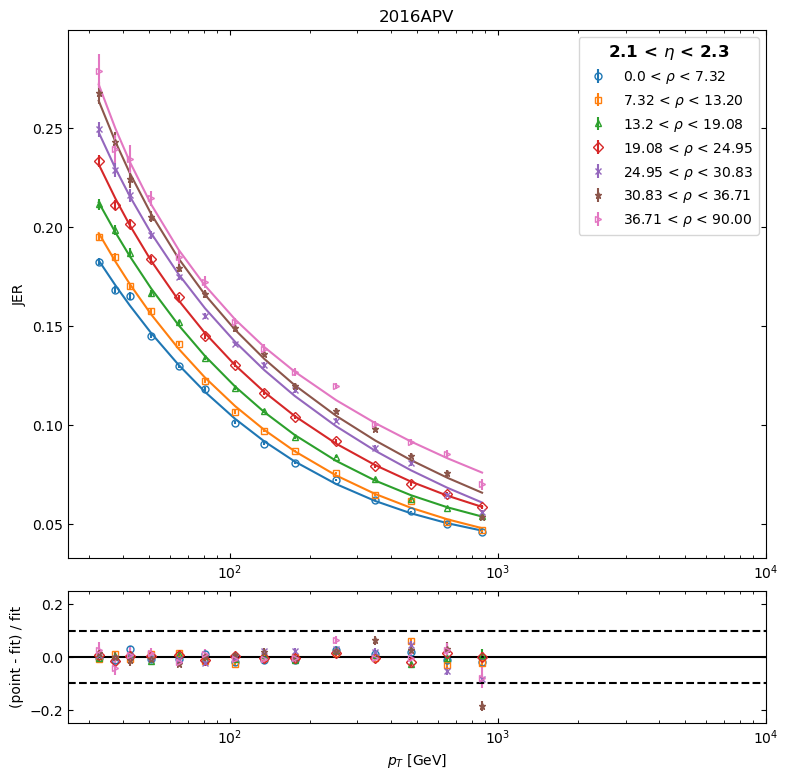

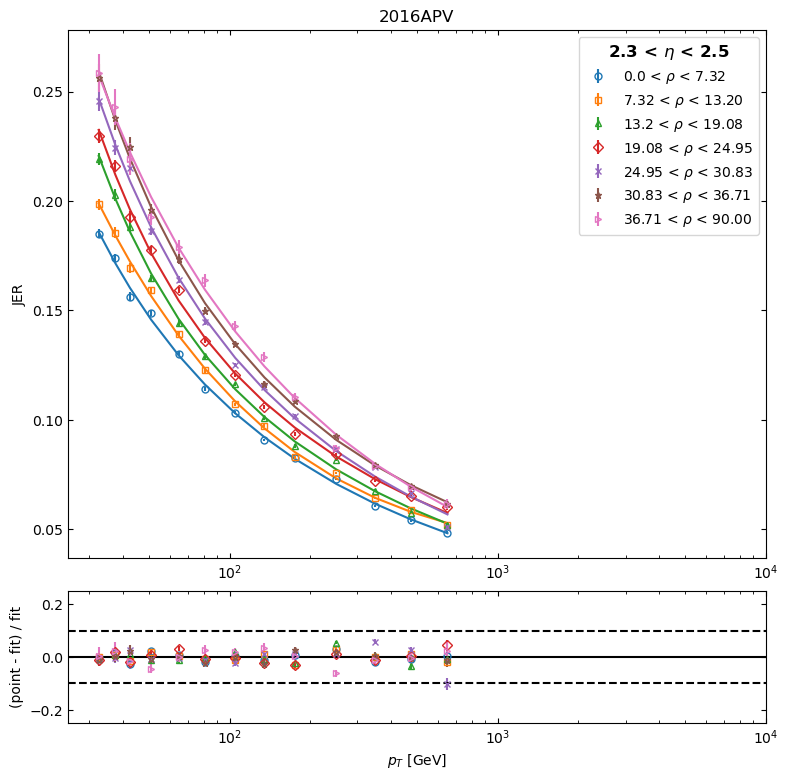

In [16]:
plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[4], sigma_errs_list=sigma_errs_lists[4], filenames_list=filenames_lists[4], jer_parameters_list=jer_parameters_lists[4], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=21) 

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[5], sigma_errs_list=sigma_errs_lists[5], filenames_list=filenames_lists[5], jer_parameters_list=jer_parameters_lists[5], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=17)          # Covariance error when running full notebook

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[6], sigma_errs_list=sigma_errs_lists[6], filenames_list=filenames_lists[6], jer_parameters_list=jer_parameters_lists[6], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=17) 

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[7], sigma_errs_list=sigma_errs_lists[7], filenames_list=filenames_lists[7], jer_parameters_list=jer_parameters_lists[7], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=16) 

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[8], sigma_errs_list=sigma_errs_lists[8], filenames_list=filenames_lists[8], jer_parameters_list=jer_parameters_lists[8], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=15) 

### Forward measurements

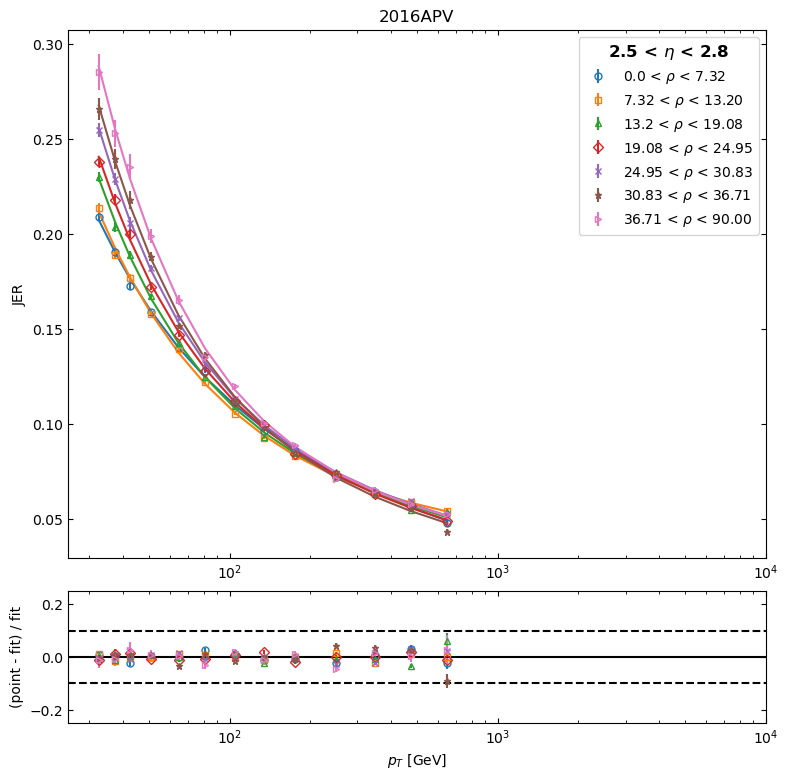

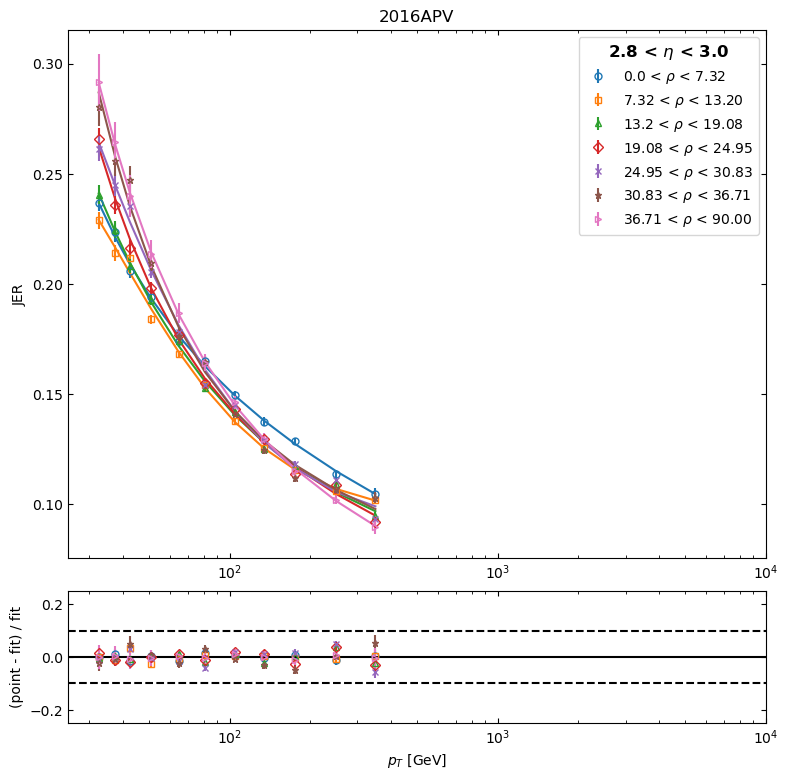

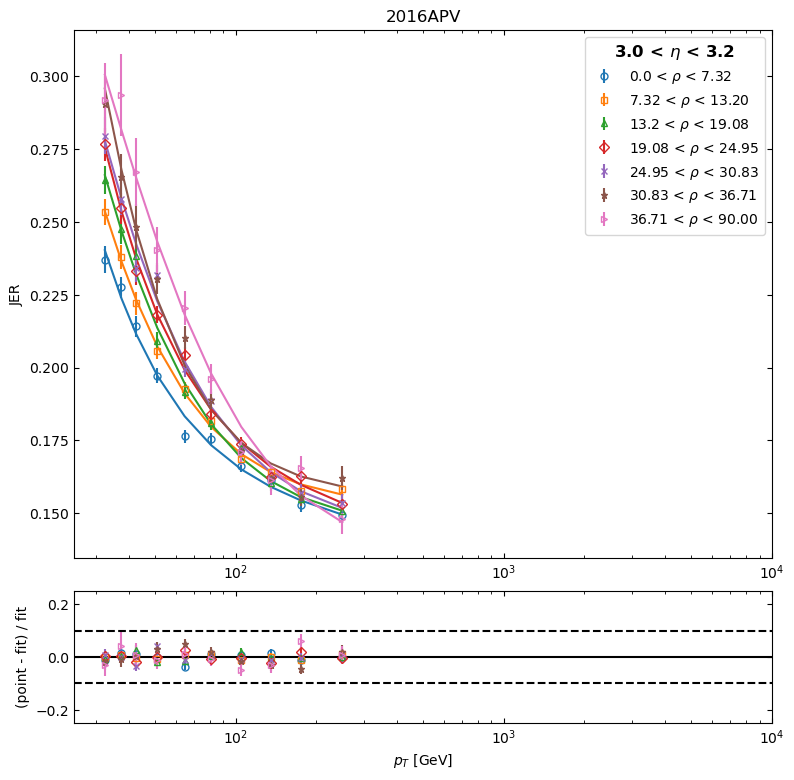

/home/cms-jovyan/QCD_JER_Analysis/Jet_Energy_Resolution/python/smp_utils.py:192: RuntimeWarning: overflow encountered in power
  return np.sqrt(parameter_0 * np.abs(parameter_0) / (pt * pt) + parameter_1 * parameter_1 * np.power(pt, parameter_3) + parameter_2 * parameter_2)


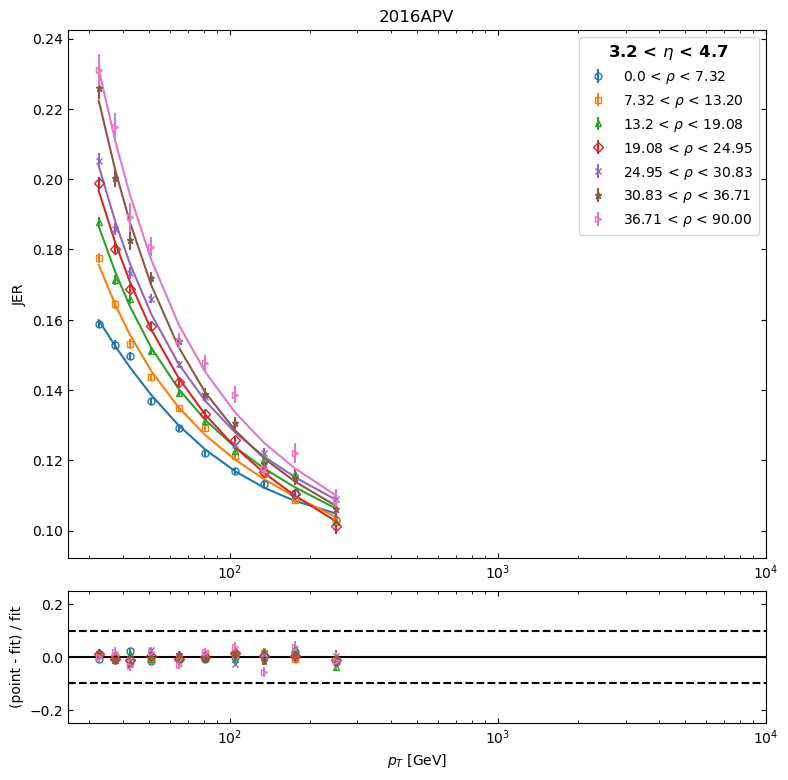

In [17]:
plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[9], sigma_errs_list=sigma_errs_lists[9], filenames_list=filenames_lists[9], jer_parameters_list=jer_parameters_lists[9], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=15)           # Covariance error when running single cell

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[10], sigma_errs_list=sigma_errs_lists[10], filenames_list=filenames_lists[10], jer_parameters_list=jer_parameters_lists[10], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=13)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[11], sigma_errs_list=sigma_errs_lists[11], filenames_list=filenames_lists[11], jer_parameters_list=jer_parameters_lists[11], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=12)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[12], sigma_errs_list=sigma_errs_lists[12], filenames_list=filenames_lists[12], jer_parameters_list=jer_parameters_lists[12], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=12)          # Covariance error when running full notebook

### 2016 Dataset

In [18]:
era = 2016

eta_ranges = [
    (0.0, 0.5), (0.5, 0.8), (0.8, 1.1), (1.1, 1.3), (1.3, 1.7),
    (1.7, 1.9), (1.9, 2.1), (2.1, 2.3), (2.3, 2.5), (2.5, 2.8),
    (2.8, 3.0), (3.0, 3.2), (3.2, 4.7)
]

rho_ranges = [(0., 7.32), (7.32, 13.2), (13.2, 19.08), (19.08, 24.95), (24.95, 30.83), (30.83, 36.71), (36.71, 90)]

jer_parameters_lists = []
calculated_jer_lists = []

for i, eta_range in enumerate(eta_ranges):
    jer_calculator = JERCalculator("../jer_files/Summer20UL16_JRV3_MC_PtResolution_AK4PFchs.txt", eta_min=eta_range[0], eta_max=eta_range[1], rho_min=0, rho_max=90)
    
    jer_parameters = jer_calculator.extract_parameters()
    calculated_jer = jer_calculator.compute_jer(pt_bin_centers)
    
    jer_parameters_lists.append(jer_parameters)
    calculated_jer_lists.append(calculated_jer)

pt_bin_lists = []
sigmas_lists = []
sigma_errs_lists = []
filenames_lists = []
dfs_lists = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists.append(pt_bins)
    sigmas_lists.append(sigmas)
    sigma_errs_lists.append(sigma_errs)
    filenames_lists.append(filenames)
    dfs_lists.append(dfs)

### Barrel measurements

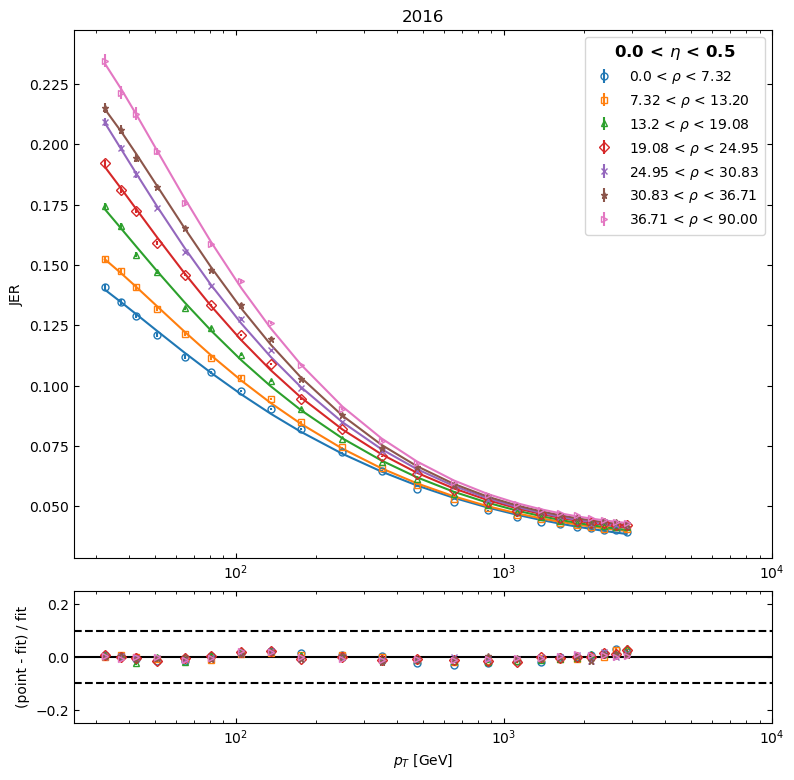

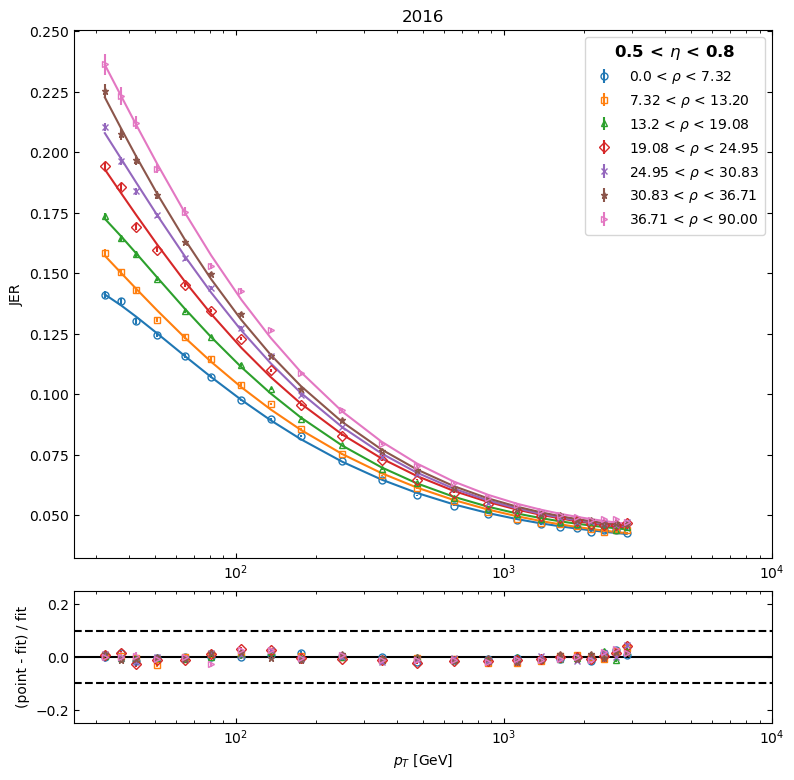

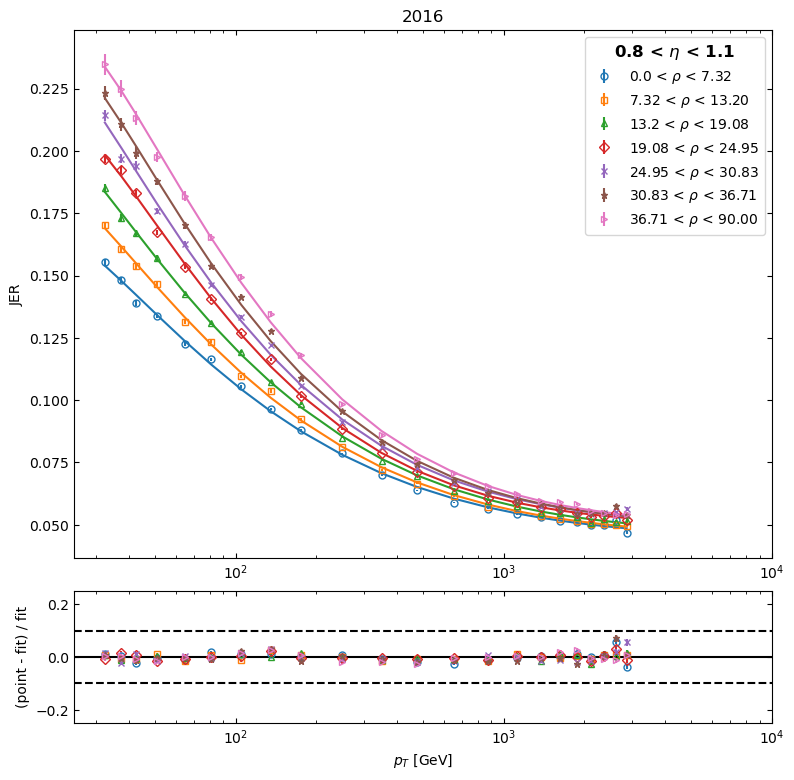

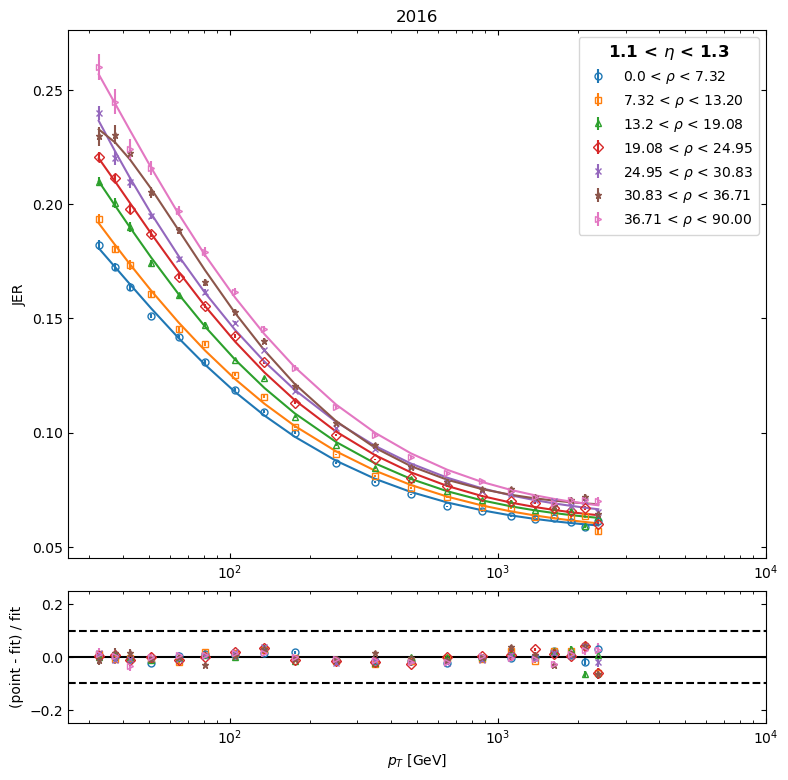

In [19]:
plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[0], sigma_errs_list=sigma_errs_lists[0], filenames_list=filenames_lists[0], jer_parameters_list=jer_parameters_lists[0], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=24)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[1], sigma_errs_list=sigma_errs_lists[1], filenames_list=filenames_lists[1], jer_parameters_list=jer_parameters_lists[1], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=24)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[2], sigma_errs_list=sigma_errs_lists[2], filenames_list=filenames_lists[2], jer_parameters_list=jer_parameters_lists[2], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=24)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[3], sigma_errs_list=sigma_errs_lists[3], filenames_list=filenames_lists[3], jer_parameters_list=jer_parameters_lists[3], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=22)

### Endcap measurements

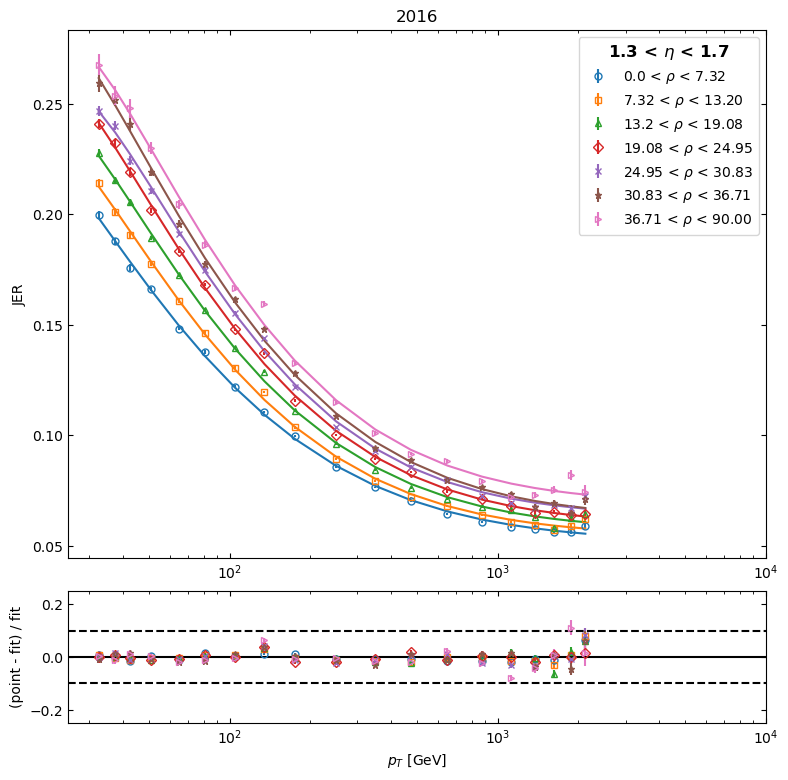

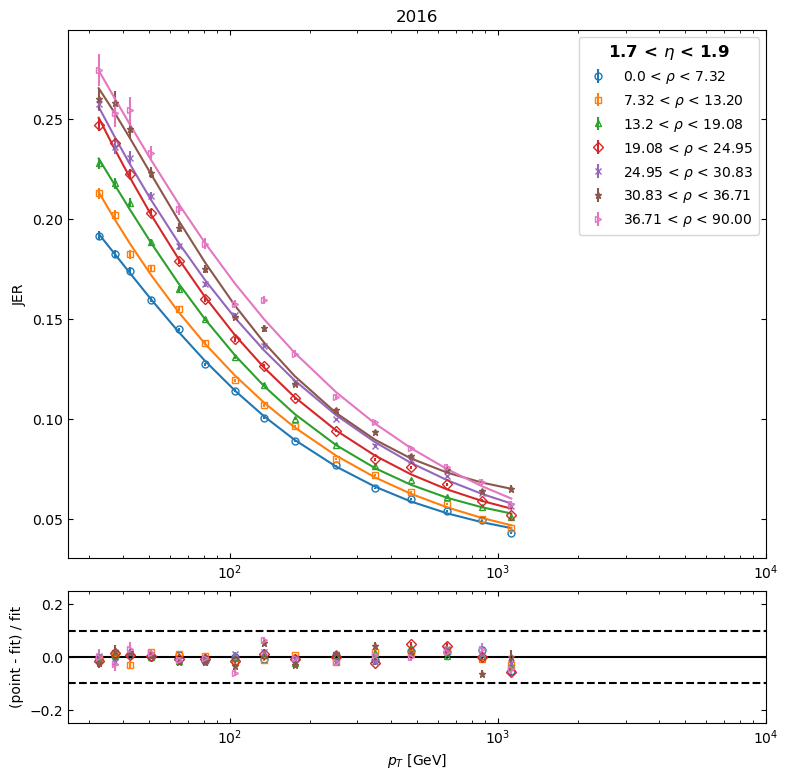

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


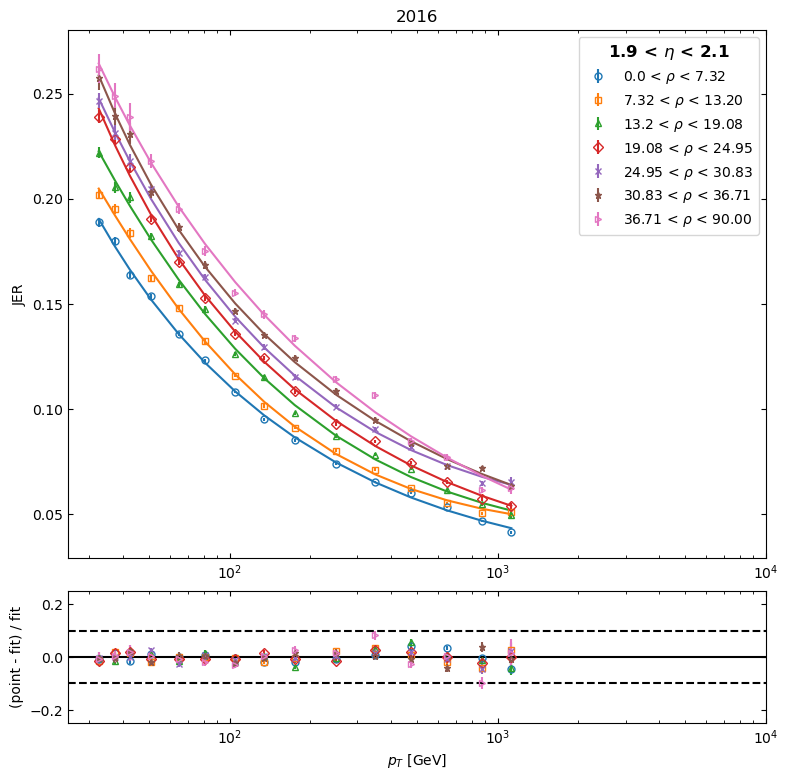

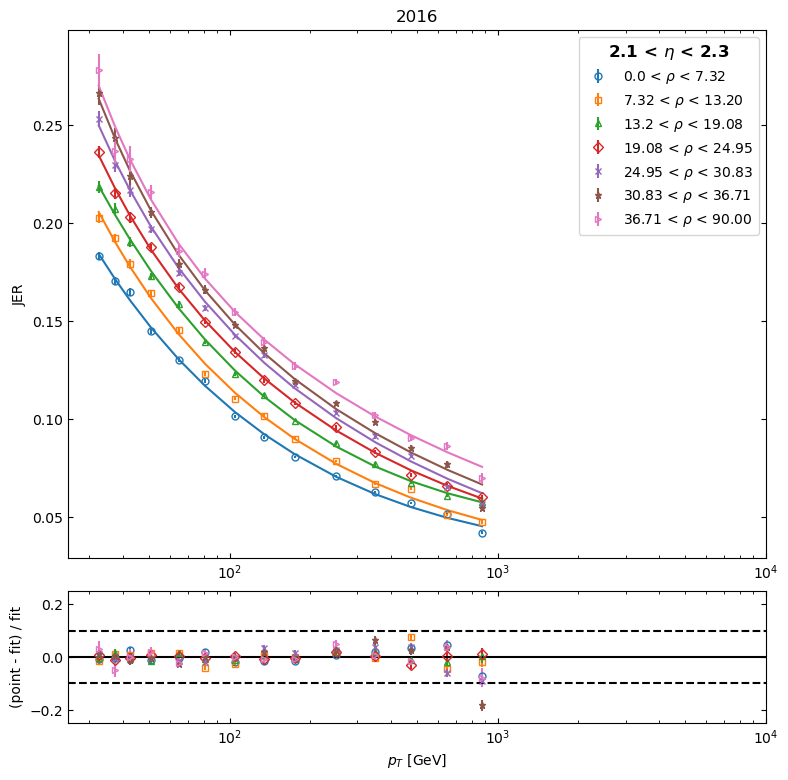

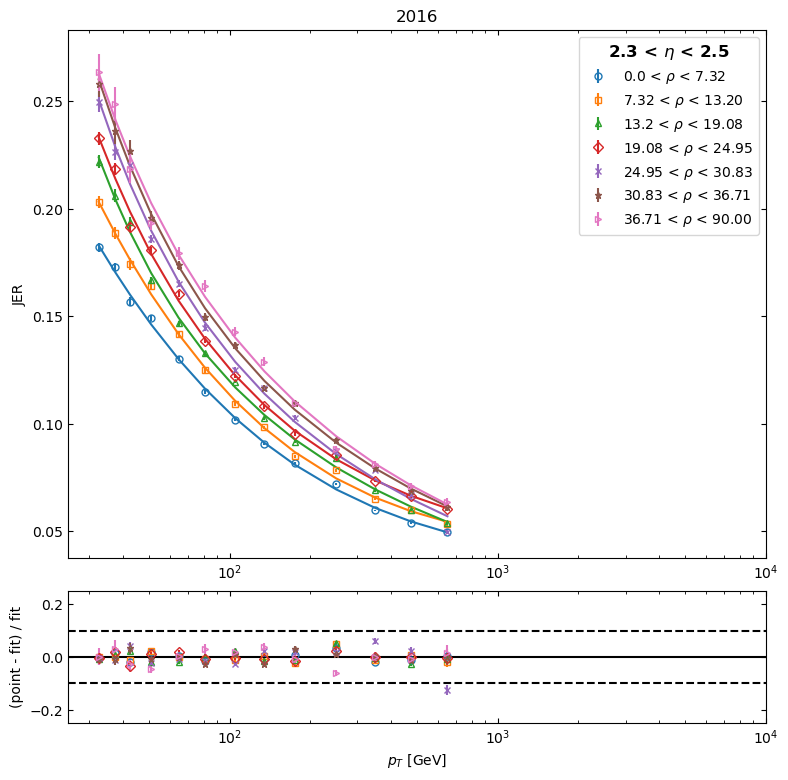

In [20]:
plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[4], sigma_errs_list=sigma_errs_lists[4], filenames_list=filenames_lists[4], jer_parameters_list=jer_parameters_lists[4], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=21)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[5], sigma_errs_list=sigma_errs_lists[5], filenames_list=filenames_lists[5], jer_parameters_list=jer_parameters_lists[5], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=17)          # Covariance error when running full notebook

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[6], sigma_errs_list=sigma_errs_lists[6], filenames_list=filenames_lists[6], jer_parameters_list=jer_parameters_lists[6], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=17)         

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[7], sigma_errs_list=sigma_errs_lists[7], filenames_list=filenames_lists[7], jer_parameters_list=jer_parameters_lists[7], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=16)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[8], sigma_errs_list=sigma_errs_lists[8], filenames_list=filenames_lists[8], jer_parameters_list=jer_parameters_lists[8], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=15)

### Forward measurements

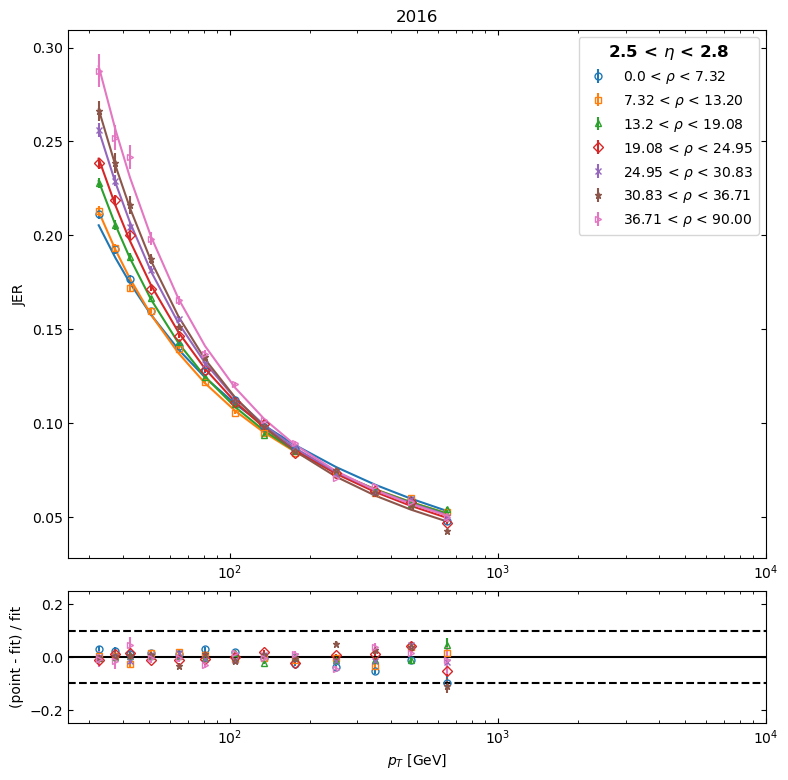

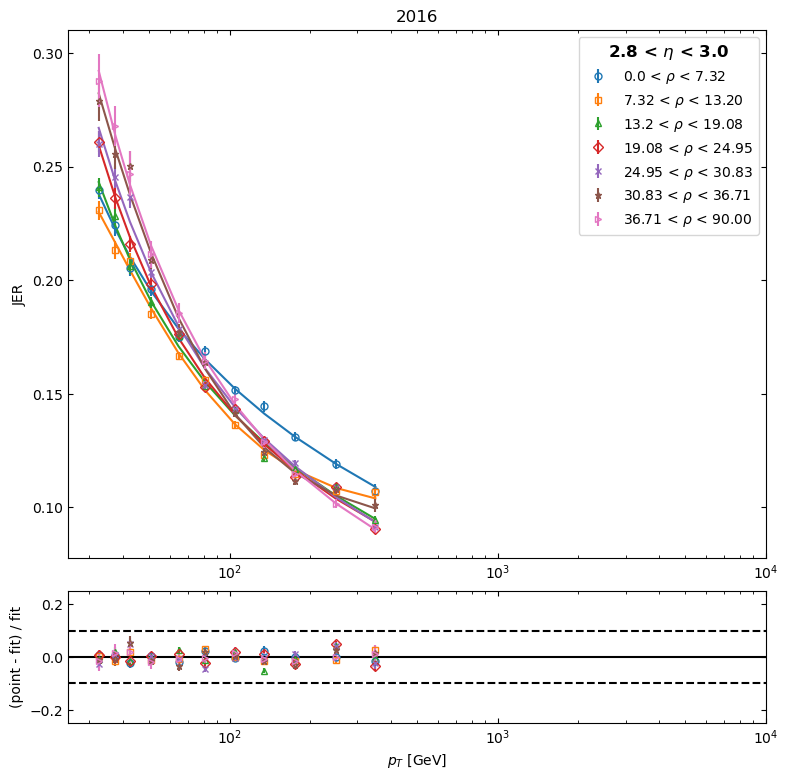

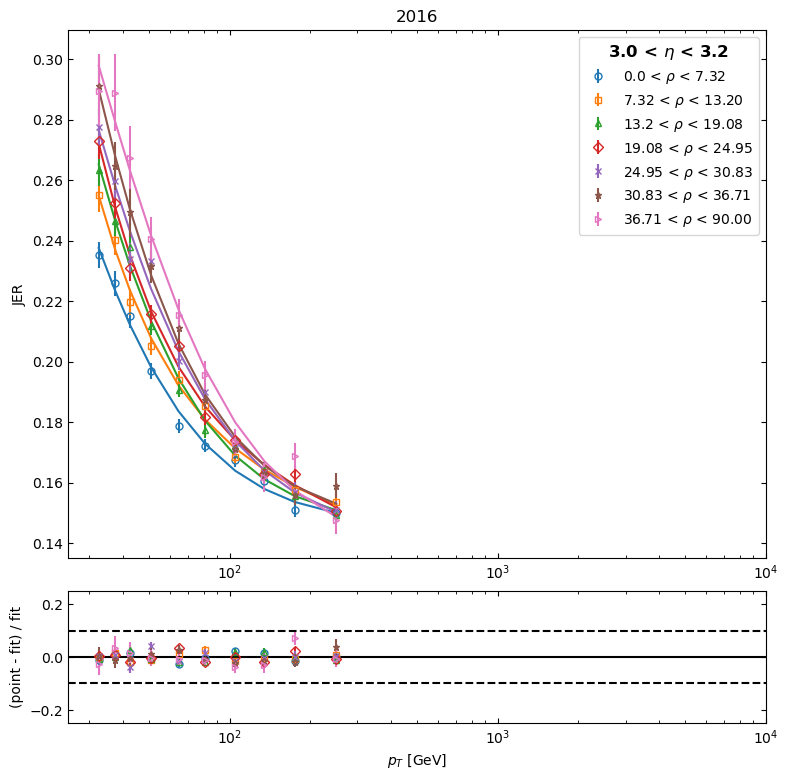

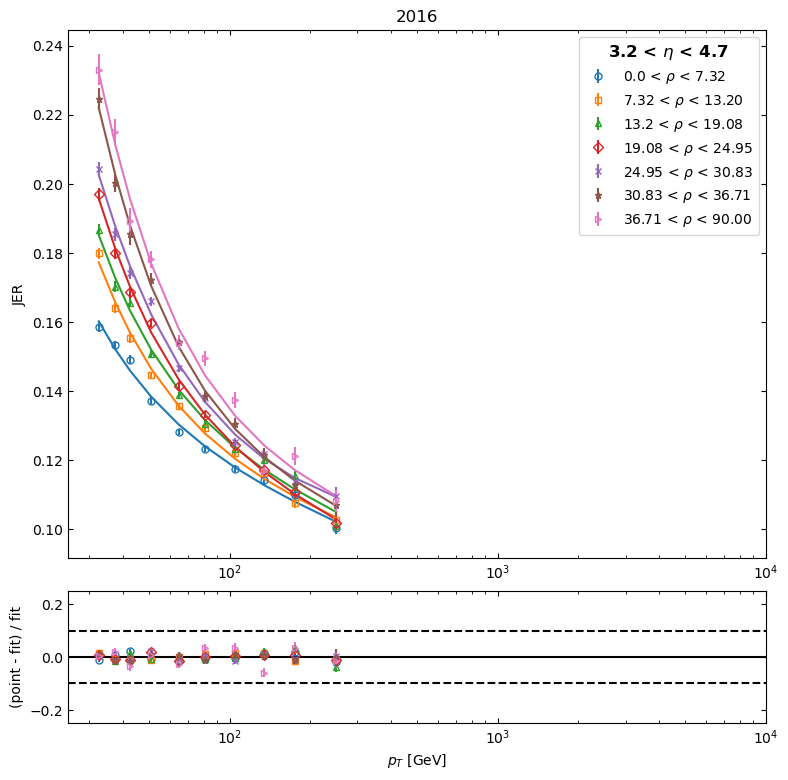

In [21]:
plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[9], sigma_errs_list=sigma_errs_lists[9], filenames_list=filenames_lists[9], jer_parameters_list=jer_parameters_lists[9], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=15)           # Covariance error when running single cell

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[10], sigma_errs_list=sigma_errs_lists[10], filenames_list=filenames_lists[10], jer_parameters_list=jer_parameters_lists[10], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=13)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[11], sigma_errs_list=sigma_errs_lists[11], filenames_list=filenames_lists[11], jer_parameters_list=jer_parameters_lists[11], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=12)

plot_jer(pt_bin_list=pt_bin_centers, sigmas_list=sigmas_lists[12], sigma_errs_list=sigma_errs_lists[12], filenames_list=filenames_lists[12], jer_parameters_list=jer_parameters_lists[12], 
         lower_xlimit=25, upper_xlimit=10000, lower_pt_bin=2, upper_pt_bin=12)